# 11. Improvements to initial Unsupervised LDA

In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive', force_remount=True) # Adding force_remount=True to force the remounting process

Mounted at /content/drive


In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/train_data.csv')
train_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,reviews,date_reviews,rating,course_id,month,departments,name,institution,sentiment_from_rating,emotion_label,sentiment_label_from_review
0,46979,43342,52189,Andrew Ng has provided a fantastic resource fo...,2017-09-12,5,machine-learning,2017-09,Computer Science,Machine Learning,Stanford University,positive,admiration,positive
1,15087,27963,33570,Peer graded assingments take a lot of time bec...,2020-06-14,4,python-databases,2020-06,Computer Science,Using Databases with Python,University of Michigan,positive,neutral,positive
2,32265,3290,4397,This course was the first actual course for Pr...,2019-01-31,5,python,2019-01,Computer Science,Programming for Everybody (Getting Started wit...,University of Michigan,positive,admiration,positive
3,44070,43900,52762,The best course to start with if you are enter...,2017-08-20,5,machine-learning,2017-08,Computer Science,Machine Learning,Stanford University,positive,approval,positive
4,18016,34850,42219,I wanted to learn more about Functional Progra...,2020-07-12,4,programming-languages,2020-07,Computer Science,"Programming Languages, Part A",University of Washington,positive,approval,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39733,14444,32000,38501,This course is one of the best courses that sh...,2019-02-12,4,python-data-visualization,2019-02,Computer Science,"Capstone: Retrieving, Processing, and Visualiz...",University of Michigan,positive,admiration,positive
39734,46433,25044,30104,"The details about Objects, References and Alia...",2019-08-08,4,python-basics,2019-08,Computer Science,Python Basics,University of Michigan,positive,admiration,positive
39735,22140,27877,33439,This course gives very basic information about...,2016-02-19,4,python-databases,2016-02,Computer Science,Using Databases with Python,University of Michigan,positive,admiration,positive
39736,29009,2544,3541,Awesome courseDr. Chuck is great,2019-02-03,4,python,2019-02,Computer Science,Programming for Everybody (Getting Started wit...,University of Michigan,positive,admiration,positive


In [ ]:
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Defining Stopwords to make the topic summaries more specific/related to a topic

In [ ]:
import pandas as pd
import torch
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import os
from gensim.models import CoherenceModel

# Download NLTK stopwords and punkt
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Custom stopwords list based on the provided LDA topics
custom_stopwords = set([
    "andrew", "ng", "chuck",  # Names specific to the course or instructor
    "python", "programming", "machine", "data", "science", "learning",  # Subject-specific words
    "lot", "really", "thank", "would", "could", "videos", "introduction", "beginners", "bit", "little", "like", "well",  # Common but generic words
    "best", "great", "good", "course",  # Common words that can still give useful context
])

data = {'reviews': ['The grading system was unclear.',
                    'The course material was outdated.',
                    'I enjoyed the lectures, but the workload was too high.',
                    'Assignments were good, but could use better feedback.',
                    'The instructor was excellent, but the exams were difficult.'],
        'course_id': ['python']*5}
df_reviews = pd.DataFrame(data)

# Preprocessing function with a check for NaN or non-string values
def preprocess(text, custom_stopwords):
    if not isinstance(text, str):  # Check if the text is a string
        return []  # Return an empty list if the text is not a string or is NaN
    tokens = word_tokenize(text.lower())  # Tokenizing and converting to lowercase
    tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
    return tokens

# Function to get top topics for each LDA model
def get_topic_label(lda_model, corpus, num_topics):
    topic_labels = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        dominant_topic = max(topics, key=lambda x: x[1])[0]  # Get the topic with the highest probability
        topic_labels.append(f"Topic {dominant_topic + 1}")
    return topic_labels

# Function to get LDA topic summaries (top words for each topic)
def get_lda_topic_summary(lda_model, num_topics, top_n=5):
    summary = {}
    for i in range(num_topics):
        words = lda_model.show_topic(i, topn=top_n)
        topic_keywords = " + ".join([f'{weight:.3f}*\"{word}\"' for word, weight in words])
        summary[f"Topic {i+1}"] = topic_keywords
    return summary

# Updated function to compute coherence score and perplexity
def compute_coherence_score(lda_model, corpus, dictionary):
    try:
        print("Computing coherence score...")
        coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        print(f"Coherence score calculated: {coherence_score}")
        return coherence_score
    except Exception as e:
        print(f"Error calculating coherence score: {e}")
        return None

# Updated function to compute perplexity score
def compute_perplexity(lda_model, corpus):
    try:
        print("Computing perplexity score...")
        perplexity_score = lda_model.log_perplexity(corpus)
        print(f"Perplexity score calculated: {perplexity_score}")
        return perplexity_score
    except Exception as e:
        print(f"Error calculating perplexity score: {e}")
        return None

# Updated main function for running LDA with labels, summaries, coherence, and perplexity
def run_lda_with_labels_and_summaries(df_reviews, topic_range=(3, 6), batch_size=100, checkpoint_dir="/content/drive/MyDrive/checkpoints_boo"):
    all_topic_labels = {}
    all_topic_summaries = {}
    coherence_scores = {}
    perplexity_scores = {}

    # Preprocess the reviews
    df_reviews = df_reviews.copy()  # Ensures modifications are on a copy of the original DataFrame
    df_reviews['reviews'] = df_reviews['reviews'].fillna('').astype(str)  # Handle missing reviews
    df_reviews['processed_reviews'] = df_reviews['reviews'].apply(lambda text: preprocess(text, custom_stopwords))

    # Create dictionary and corpus for LDA
    dictionary = corpora.Dictionary(df_reviews['processed_reviews'])
    corpus = [dictionary.doc2bow(review) for review in df_reviews['processed_reviews']]

    print("Corpus sample:", corpus[:2])  # Printing sample of the corpus for debugging

    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Loop through different topic numbers (from topic_range)
    for num_topics in range(topic_range[0], topic_range[1] + 1):
        checkpoint_file = os.path.join(checkpoint_dir, f"lda_model_{num_topics}_topics.pth")

        # Load checkpoint if it exists
        if os.path.exists(checkpoint_file):
            print(f"Loading LDA checkpoint for {num_topics} topics from {checkpoint_file}.")
            checkpoint = torch.load(checkpoint_file)
            all_topic_labels[f'LDA_topic_{num_topics}'] = checkpoint['topic_labels']
            all_topic_summaries[f'LDA_summary_{num_topics}_topics'] = checkpoint['topic_summary']
            continue

        # Train LDA model with num_topics
        print(f"Training LDA model with {num_topics} topics...")
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

        # Get topic labels for each review
        topic_labels = get_topic_label(lda_model, corpus, num_topics)
        all_topic_labels[f'LDA_topic_{num_topics}'] = topic_labels

        # Get topic summary (top words) for the current LDA model
        topic_summary = get_lda_topic_summary(lda_model, num_topics)
        all_topic_summaries[f'LDA_summary_{num_topics}_topics'] = topic_summary

        # Compute coherence score
        coherence_score = compute_coherence_score(lda_model, corpus, dictionary)
        coherence_scores[f'LDA_coherence_{num_topics}_topics'] = coherence_score
        print(f"Coherence Score for {num_topics} topics: {coherence_score}")

        # Compute perplexity score
        perplexity_score = compute_perplexity(lda_model, corpus)
        perplexity_scores[f'LDA_perplexity_{num_topics}_topics'] = perplexity_score
        print(f"Perplexity Score for {num_topics} topics: {perplexity_score}")

        # Assign the topic labels and summary to the DataFrame using .loc
        df_reviews[f'LDA_topic_{num_topics}'] = topic_labels
        df_reviews[f'LDA_summary_{num_topics}_topics'] = [topic_summary] * len(df_reviews)

        # Save checkpoint
        torch.save({
            'topic_labels': topic_labels,
            'topic_summary': topic_summary
        }, checkpoint_file)

        print(f"Processed LDA with {num_topics} topics and saved checkpoint to {checkpoint_file}.")

    # Return the updated dataframe, summaries, and coherence/perplexity scores
    return df_reviews, all_topic_summaries, coherence_scores, perplexity_scores

# Run LDA for topic numbers 3 to 6 and add topic labels and summaries to the dataframe
df_reviews_with_topics, lda_summaries, coherence_scores, perplexity_scores = run_lda_with_labels_and_summaries(df_reviews, topic_range=(3, 6), batch_size=100)

# Display the dataframe with the added topic columns and summaries
print(df_reviews_with_topics)

# Print the summaries for each topic number
for topic_num, summary in lda_summaries.items():
    print(f"{topic_num}:")
    for topic, keywords in summary.items():
        print(f"{topic}: {keywords}")
    print("\n")

# Print the coherence scores for each topic model
print("\nCoherence Scores:")
for topic_num, score in coherence_scores.items():
    print(f"{topic_num}: {score}")

# Print the perplexity scores for each topic model
print("\nPerplexity Scores:")
for topic_num, score in perplexity_scores.items():
    print(f"{topic_num}: {score}")


Corpus sample: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(2, 1), (4, 1), (5, 1), (6, 1)]]
Loading LDA checkpoint for 3 topics from /content/drive/MyDrive/checkpoints_boo/lda_model_3_topics.pth.
Loading LDA checkpoint for 4 topics from /content/drive/MyDrive/checkpoints_boo/lda_model_4_topics.pth.
Loading LDA checkpoint for 5 topics from /content/drive/MyDrive/checkpoints_boo/lda_model_5_topics.pth.
Loading LDA checkpoint for 6 topics from /content/drive/MyDrive/checkpoints_boo/lda_model_6_topics.pth.
                                             reviews course_id  \
0                    The grading system was unclear.    python   
1                  The course material was outdated.    python   
2  I enjoyed the lectures, but the workload was t...    python   
3  Assignments were good, but could use better fe...    python   
4  The instructor was excellent, but the exams we...    python   

                                   processed_reviews  
0               [the, grading, system, w

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-21-a7f99103d99b>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case 

In [ ]:
import pandas as pd
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import string

# Download NLTK stopwords and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')

# Define a simple text preprocessing function
def preprocess(text):
    # Tokenize and lower case
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Generate a list of random documents (for illustration purposes)
random_docs = [
    "I love programming with Python and creating amazing projects.",
    "Natural language processing is an exciting field of study.",
    "Machine learning is revolutionizing various industries with AI.",
    "Deep learning models have achieved state-of-the-art performance in many tasks.",
    "Python is a versatile language used in data science, machine learning, and web development."
]

# Create a DataFrame to hold the reviews
df_reviews = pd.DataFrame({
    'reviews': random_docs,
    'course_id': ['python'] * 5
})

# Preprocess the reviews
df_reviews['processed_reviews'] = df_reviews['reviews'].apply(preprocess)

# Create a dictionary and corpus from the processed documents
dictionary = corpora.Dictionary(df_reviews['processed_reviews'])
corpus = [dictionary.doc2bow(doc) for doc in df_reviews['processed_reviews']]

# Train an LDA model with 2 topics
lda_model = LdaModel(corpus, num_topics=2, id2word=dictionary, passes=15)

# Show topics generated by LDA
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topic {idx}: {topic}")

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_reviews['processed_reviews'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")

# Compute perplexity score
perplexity_score = lda_model.log_perplexity(corpus)
print(f"Perplexity Score: {perplexity_score}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Topic 0: 0.054*"language" + 0.053*"learning" + 0.053*"achieved" + 0.053*"many" + 0.053*"tasks"
Topic 1: 0.068*"learning" + 0.068*"python" + 0.067*"machine" + 0.040*"projects" + 0.040*"creating"
Coherence Score: 0.3273072788776139
Perplexity Score: -3.9551943710872104


In [ ]:
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import string

# Download NLTK stopwords and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')

# Define a simple text preprocessing function
def preprocess(text):
    # Tokenize and lower case
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Generate a list of random documents (for illustration purposes)
random_docs = [
    "I love programming with Python and creating amazing projects.",
    "Natural language processing is an exciting field of study.",
    "Machine learning is revolutionizing various industries with AI.",
    "Deep learning models have achieved state-of-the-art performance in many tasks.",
    "Python is a versatile language used in data science, machine learning, and web development."
]

# Preprocess the documents
processed_docs = [preprocess(doc) for doc in random_docs]

# Create a dictionary and corpus from the processed documents
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Loop through different numbers of topics (2 to 5)
for num_topics in range(2, 9):
    # Train an LDA model with the current number of topics
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Show topics generated by LDA
    print(f"\nTopics for {num_topics} topics:")
    for idx, topic in lda_model.print_topics(num_words=5):
        print(f"Topic {idx}: {topic}")

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    print(f"Coherence Score for {num_topics} topics: {coherence_score}")

    # Compute perplexity score
    perplexity_score = lda_model.log_perplexity(corpus)
    print(f"Perplexity Score for {num_topics} topics: {perplexity_score}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Topics for 2 topics:
Topic 0: 0.068*"learning" + 0.068*"language" + 0.068*"machine" + 0.041*"python" + 0.040*"science"
Topic 1: 0.054*"python" + 0.053*"deep" + 0.053*"achieved" + 0.053*"models" + 0.053*"tasks"
Coherence Score for 2 topics: 0.40024939975442236
Perplexity Score for 2 topics: -3.9551860315459115

Topics for 3 topics:
Topic 0: 0.083*"python" + 0.083*"creating" + 0.083*"amazing" + 0.083*"programming" + 0.083*"projects"
Topic 1: 0.090*"language" + 0.051*"machine" + 0.051*"field" + 0.051*"processing" + 0.051*"exciting"
Topic 2: 0.102*"learning" + 0.058*"machine" + 0.058*"deep" + 0.058*"achieved" + 0.058*"models"
Coherence Score for 3 topics: 0.3617861123958079
Perplexity Score for 3 topics: -4.085942889962878

Topics for 4 topics:
Topic 0: 0.064*"projects" + 0.064*"revolutionizing" + 0.064*"creating" + 0.064*"love" + 0.064*"various"
Topic 1: 0.033*"achieved" + 0.033*"tasks" + 0.033*"learning" + 0.033*"many" + 0.033*"models"
Topic 2: 0.096*"language" + 0.053*"machine" + 0.053

In [ ]:
import pandas as pd
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import string

# Download NLTK stopwords and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')

# Define a simple text preprocessing function
def preprocess(text):
    # Tokenize and lower case
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Sample dataframe with reviews
data = {
    'reviews': [
        "I love programming with Python and creating amazing projects.",
        "Natural language processing is an exciting field of study.",
        "Machine learning is revolutionizing various industries with AI.",
        "Deep learning models have achieved state-of-the-art performance in many tasks.",
        "Python is a versatile language used in data science, machine learning, and web development."
    ]
}

df = pd.DataFrame(data)

# Preprocess the reviews
processed_docs = [preprocess(review) for review in df['reviews']]

# Create a dictionary and corpus from the processed documents
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Loop through different numbers of topics (2 to 5)
for num_topics in range(2, 15):
    # Train an LDA model with the current number of topics
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Show topics generated by LDA
    print(f"\nTopics for {num_topics} topics:")
    for idx, topic in lda_model.print_topics(num_words=5):
        print(f"Topic {idx}: {topic}")

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    print(f"Coherence Score for {num_topics} topics: {coherence_score}")

    # Compute perplexity score
    perplexity_score = lda_model.log_perplexity(corpus)
    print(f"Perplexity Score for {num_topics} topics: {perplexity_score}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Topics for 2 topics:
Topic 0: 0.080*"learning" + 0.048*"machine" + 0.047*"language" + 0.047*"python" + 0.047*"web"
Topic 1: 0.046*"projects" + 0.046*"creating" + 0.046*"amazing" + 0.046*"love" + 0.046*"natural"
Coherence Score for 2 topics: 0.36290537647663806
Perplexity Score for 2 topics: -3.9970285415649416

Topics for 3 topics:
Topic 0: 0.084*"language" + 0.083*"field" + 0.083*"exciting" + 0.083*"processing" + 0.083*"natural"
Topic 1: 0.033*"programming" + 0.033*"love" + 0.033*"creating" + 0.033*"projects" + 0.033*"amazing"
Topic 2: 0.086*"learning" + 0.060*"machine" + 0.060*"python" + 0.034*"development" + 0.034*"web"
Coherence Score for 3 topics: 0.39463503665913297
Perplexity Score for 3 topics: -4.256154162543161

Topics for 4 topics:
Topic 0: 0.093*"python" + 0.093*"love" + 0.093*"amazing" + 0.093*"projects" + 0.093*"programming"
Topic 1: 0.076*"language" + 0.076*"machine" + 0.076*"learning" + 0.042*"field" + 0.042*"study"
Topic 2: 0.033*"learning" + 0.033*"versatile" + 0.033

In [ ]:
import pandas as pd
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import string

# Download NLTK stopwords and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')

# Define a simple text preprocessing function
def preprocess(text):
    # Tokenize and lower case
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Sample dataframe with reviews
data = {
    'reviews': [
        "I love programming with Python and creating amazing projects.",
        "Natural language processing is an exciting field of study.",
        "Machine learning is revolutionizing various industries with AI.",
        "Deep learning models have achieved state-of-the-art performance in many tasks.",
        "Python is a versatile language used in data science, machine learning, and web development."
    ]
}

df = pd.DataFrame(data)

# Preprocess the reviews
processed_docs = [preprocess(review) for review in df['reviews']]

# Create a dictionary and corpus from the processed documents
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Initialize variables to track the best and worst scores
max_perplexity = float('-inf')
min_perplexity = float('inf')
max_coherence = float('-inf')
min_coherence = float('inf')

best_perplexity_topics = None
worst_perplexity_topics = None
best_coherence_topics = None
worst_coherence_topics = None

# Loop through different numbers of topics (2 to 5)
for num_topics in range(2, 20):
    # Train an LDA model with the current number of topics
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Show topics generated by LDA
    print(f"\nTopics for {num_topics} topics:")
    for idx, topic in lda_model.print_topics(num_words=5):
        print(f"Topic {idx}: {topic}")

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    print(f"Coherence Score for {num_topics} topics: {coherence_score}")

    # Compute perplexity score
    perplexity_score = lda_model.log_perplexity(corpus)
    print(f"Perplexity Score for {num_topics} topics: {perplexity_score}")

    # Track maximum and minimum perplexity
    if perplexity_score > max_perplexity:
        max_perplexity = perplexity_score
        best_perplexity_topics = num_topics

    if perplexity_score < min_perplexity:
        min_perplexity = perplexity_score
        worst_perplexity_topics = num_topics

    # Track maximum and minimum coherence
    if coherence_score > max_coherence:
        max_coherence = coherence_score
        best_coherence_topics = num_topics

    if coherence_score < min_coherence:
        min_coherence = coherence_score
        worst_coherence_topics = num_topics

# After loop, print the results
print(f"\nTopic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")
print(f"Topic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Topics for 2 topics:
Topic 0: 0.044*"many" + 0.044*"deep" + 0.044*"achieved" + 0.044*"models" + 0.044*"performance"
Topic 1: 0.082*"learning" + 0.080*"machine" + 0.049*"python" + 0.049*"language" + 0.048*"used"
Coherence Score for 2 topics: 0.37825165468517674
Perplexity Score for 2 topics: -3.9690185035978045

Topics for 3 topics:
Topic 0: 0.084*"language" + 0.083*"natural" + 0.083*"exciting" + 0.083*"processing" + 0.083*"field"
Topic 1: 0.084*"python" + 0.083*"love" + 0.083*"projects" + 0.083*"programming" + 0.083*"creating"
Topic 2: 0.101*"learning" + 0.071*"machine" + 0.040*"deep" + 0.040*"models" + 0.040*"tasks"
Coherence Score for 3 topics: 0.3439303306158476
Perplexity Score for 3 topics: -4.1157861300877165

Topics for 4 topics:
Topic 0: 0.096*"learning" + 0.096*"machine" + 0.053*"python" + 0.053*"language" + 0.053*"used"
Topic 1: 0.033*"python" + 0.033*"language" + 0.033*"learning" + 0.033*"industries" + 0.033*"revolutionizing"
Topic 2: 0.086*"learning" + 0.086*"models" + 0.0

1. Coherence Score:
Definition: The coherence score evaluates how semantically consistent the words in a topic are with each other. It measures how often the top words of a topic appear together in the same documents, based on some statistical measures (e.g., c_v coherence, which is based on word pairs appearing frequently together across documents).
Range: The coherence score typically ranges from 0 to 1, with higher values indicating better coherence. A higher score means the words in a topic are more likely to appear together in the same documents, implying that the topic is more meaningful and interpretable.
Interpretation:
0.33 (as in your case, Coherence Score: 0.3273) is generally a moderate coherence score. A score above 0.3 is often seen as acceptable for many text corpora. However, the exact threshold for "good" coherence varies based on the domain and dataset.
A high coherence score indicates that the topics are likely to represent meaningful concepts or themes in the data.
A low coherence score suggests that the words in the topic may not have a clear relationship, or that the model hasn't captured strong, interpretable topics.
2. Perplexity Score:
Definition: Perplexity is a measure of how well the model predicts the sample. It is the inverse of the probability of the test set, normalized by the number of words. Essentially, it measures the uncertainty of the model: lower perplexity indicates a better fit to the data, meaning the model's topics represent the data well.
Range: Perplexity is always a positive number. In practice, a lower perplexity score indicates a better model, but it is often less interpretable compared to the coherence score.

How to Interpret Scores Together:
High coherence and low perplexity: These are ideal. You have interpretable topics, and the model is good at predicting words.
High coherence but high perplexity: This can occur if the topics are meaningful, but the model is overfitting or not generalizing well. You may need to adjust the number of topics or passes.
Low coherence and low perplexity: This suggests that the topics are not meaningful, but the model fits the data well in terms of prediction. It’s a sign that you should focus on improving the topic modeling aspects (e.g., increasing the number of topics or adjusting the preprocessing).
Low coherence and high perplexity: This is the worst case, as it suggests the model is neither predictive nor interpretable. You should consider adjusting your model parameters or preprocessing steps.

paper link to justify metrics:
https://www.researchgate.net/publication/359926670_A_comparison_study_between_coherence_and_perplexity_for_determining_the_number_of_topics_in_practitioners_interviews_analysis


**Can use first run results to determine further preprocessing steps to be done**

Using previous results to decide which words to ignore:
LDA_summary_3_topics:
Topic 1: 0.089*"course" + 0.055*"python" + 0.042*"good" + 0.029*"data" + 0.028*"programming"
Topic 2: 0.049*"course" + 0.014*"really" + 0.013*"thank" + 0.013*"great" + 0.011*"lot"
Topic 3: 0.051*"learning" + 0.048*"course" + 0.031*"machine" + 0.017*"andrew" + 0.017*"well"


LDA_summary_4_topics:
Topic 1: 0.088*"course" + 0.046*"python" + 0.028*"programming" + 0.024*"great" + 0.022*"learn"
Topic 2: 0.017*"course" + 0.016*"assignments" + 0.013*"time" + 0.013*"would" + 0.010*"could"
Topic 3: 0.073*"course" + 0.058*"good" + 0.045*"data" + 0.029*"great" + 0.022*"introduction"
Topic 4: 0.053*"course" + 0.044*"learning" + 0.031*"machine" + 0.017*"andrew" + 0.015*"ng"


LDA_summary_5_topics:
Topic 1: 0.022*"course" + 0.022*"assignments" + 0.013*"time" + 0.013*"would" + 0.011*"videos"
Topic 2: 0.056*"learning" + 0.053*"course" + 0.043*"machine" + 0.027*"data" + 0.015*"good"
Topic 3: 0.096*"course" + 0.052*"python" + 0.045*"good" + 0.038*"programming" + 0.027*"great"
Topic 4: 0.075*"course" + 0.033*"thank" + 0.025*"really" + 0.024*"lot" + 0.023*"learning"
Topic 5: 0.038*"course" + 0.037*"best" + 0.037*"courses" + 0.031*"one" + 0.021*"chuck"


LDA_summary_6_topics:
Topic 1: 0.083*"course" + 0.034*"easy" + 0.029*"really" + 0.029*"great" + 0.023*"thank"
Topic 2: 0.082*"learning" + 0.059*"course" + 0.051*"machine" + 0.028*"andrew" + 0.025*"ng"
Topic 3: 0.019*"time" + 0.015*"bit" + 0.014*"little" + 0.013*"like" + 0.013*"course"
Topic 4: 0.107*"course" + 0.061*"python" + 0.053*"programming" + 0.028*"good" + 0.027*"beginners"
Topic 5: 0.076*"data" + 0.068*"course" + 0.048*"good" + 0.035*"python" + 0.034*"science"
Topic 6: 0.036*"course" + 0.019*"assignments" + 0.018*"well" + 0.013*"good" + 0.012*"programming"

**Plan**

- compare no extra preprocessing for like 50 data points to all the extra preprocessing

- compare different steps of preprocessing, i.e., remove some of the additional ones and compare against each other

- but so far, it looks like the further preprocessing makes it worse but its probably a specific step

Testing LDA with all additonal preprocessing steps for 500 data points (instead of whole dataset to save time and decide on a appropriate number of clusters to apply to the whole dataset)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import os
import pickle
import string

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize resources
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Custom stopwords
custom_stopwords = {"python", "programming", "course", "machine", "learning", "data", "andrew", "ng", "thank"}
all_stopwords = stop_words.union(custom_stopwords)

# Synonym normalization dictionary
synonyms = {
    'ai': 'artificial intelligence',
    'ml': 'machine learning',
    'dl': 'deep learning',
    'nlp': 'natural language processing'
}

# Preprocessing functions
def normalize_text(text):
    """Replace synonyms with normalized terms."""
    for key, value in synonyms.items():
        text = text.replace(key, value)
    return text

def preprocess(text):
    """Perform text preprocessing."""
    text = normalize_text(text)  # Normalize synonyms
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return tokens

# Bigram and trigram detection function
def detect_ngrams(processed_docs):
    """Detect bigrams and trigrams."""
    bigram = Phrases(processed_docs, min_count=2, threshold=10)
    trigram = Phrases(bigram[processed_docs], threshold=10)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    processed_docs = [bigram_mod[doc] for doc in processed_docs]
    processed_docs = [trigram_mod[doc] for doc in processed_docs]
    return processed_docs

# Checkpointing functions
def save_checkpoint(data, filename):
    """Save data to a checkpoint file."""
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_checkpoint(filename):
    """Load data from a checkpoint file."""
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

# Load dataset
df = train_df.iloc[:500]  # Example: use the first 500 reviews

# Define batch size
batch_size = 100
num_batches = (len(df) + batch_size - 1) // batch_size

# Checkpoint filenames
processed_docs_checkpoint = "processed_docs_checkpoint.pkl"
dictionary_checkpoint = "dictionary_checkpoint.pkl"
lda_checkpoint = "lda_checkpoint.pkl"

# Process reviews in batches
processed_docs = load_checkpoint(processed_docs_checkpoint) or []
for batch_idx in range(num_batches):
    if batch_idx < len(processed_docs) // batch_size:  # Skip already processed batches
        continue
    batch = df['reviews'][batch_idx * batch_size:(batch_idx + 1) * batch_size]
    batch_processed = [preprocess(review) for review in batch]
    processed_docs.extend(batch_processed)
    save_checkpoint(processed_docs, processed_docs_checkpoint)
    print(f"Processed batch {batch_idx + 1}/{num_batches}")

# Detect bigrams/trigrams and filter dictionary
processed_docs = detect_ngrams(processed_docs)
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)
save_checkpoint(dictionary, dictionary_checkpoint)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Initialize lists to store scores
perplexity_scores = []
coherence_scores = []
num_topics_range = range(2, 20)

# Load previous LDA results if available
lda_results = load_checkpoint(lda_checkpoint) or {
    "perplexity_scores": [],
    "coherence_scores": [],
    "num_topics_done": 0
}

# Resume LDA modeling
start_topic = lda_results["num_topics_done"] + 1
for num_topics in num_topics_range[start_topic - 2:]:
    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

    # Compute perplexity score
    perplexity_score = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity_score)

    # Save intermediate results
    lda_results["perplexity_scores"].append(perplexity_score)
    lda_results["coherence_scores"].append(coherence_score)
    lda_results["num_topics_done"] = num_topics
    save_checkpoint(lda_results, lda_checkpoint)

    # Print topics
    print(f"\nTopics for {num_topics} topics:")
    for idx, topic in lda_model.print_topics(num_words=5):
        print(f"Topic {idx}: {topic}")
    print(f"Coherence Score: {coherence_score}")
    print(f"Perplexity Score: {perplexity_score}")

# Plotting results
plt.figure(figsize=(10, 6))

# Plot coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range[:len(coherence_scores)], coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)

# Plot perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range[:len(perplexity_scores)], perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Print the best and worst results
max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

print(f"\nTopic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")
print(f"Topic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-11-ad01068ed7f6>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_reviews'] = df['reviews'].apply(preprocess)


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9

Topic Summary:
Topic 0: machine_learning, learn, also, beginner, need
Topic 1: great, knowledge, practice, sql, basic
Topic 2: great, beginner, sql, learn, useful
Topic 3: awesome, learn, best, concept, learning
Topic 4: beginner, class, understand, solid, level

Labeled DataFrame:
                                               reviews  \
0    Andrew Ng has provided a fantastic resource fo...   
1    Peer graded assingments take a lot of time bec...   
2    This course was the first actual course for Pr...   
3    The best course to start with if you are enter...   
4    I wanted to learn more about Functional Progra...   
..                                                 ...   
495  The Experience 

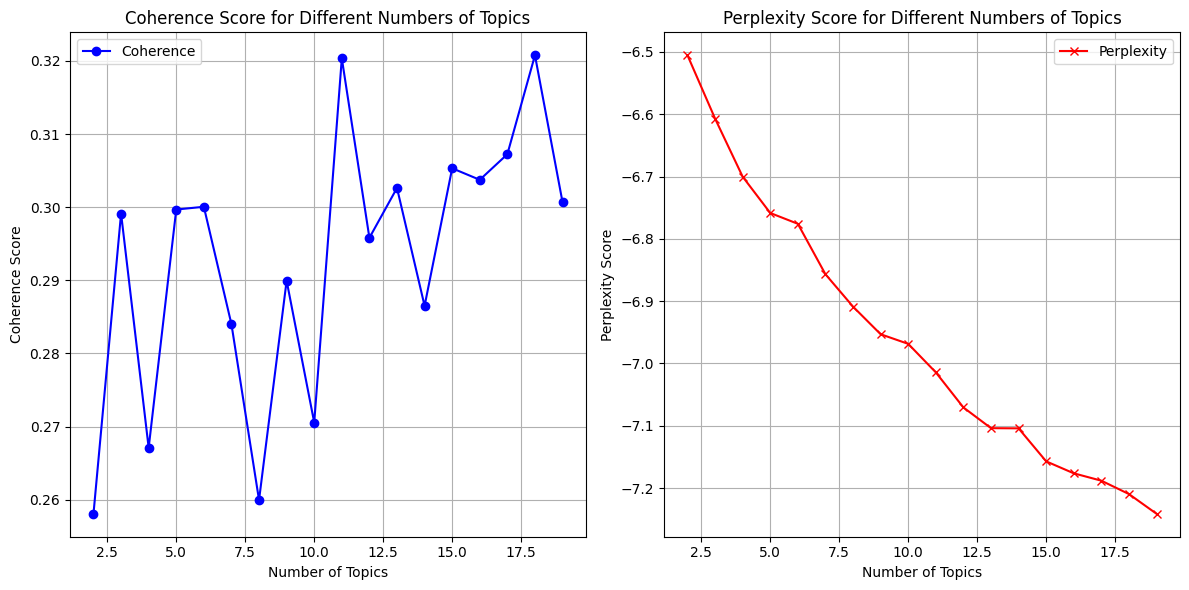

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Custom stopwords
custom_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many'}
all_stopwords = set(stopwords.words('english')).union(custom_stopwords)

# Synonym normalization dictionary
synonyms = {
    'ai': 'artificial intelligence',
    'ml': 'machine learning',
    'dl': 'deep learning',
    'nlp': 'natural language processing'
}

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing functions
def normalize_text(text):
    """Replace synonyms with normalized terms."""
    for key, value in synonyms.items():
        text = text.replace(key, value)
    return text

def preprocess(text):
    """Perform text preprocessing."""
    text = normalize_text(text)  # Normalize synonyms
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return tokens

# Bigram and trigram detection function
def detect_ngrams(processed_docs):
    """Detect bigrams and trigrams."""
    bigram = Phrases(processed_docs, min_count=2, threshold=10)
    trigram = Phrases(bigram[processed_docs], threshold=10)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    processed_docs = [bigram_mod[doc] for doc in processed_docs]
    processed_docs = [trigram_mod[doc] for doc in processed_docs]
    return processed_docs

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Load and preprocess data
df = train_df.iloc[:500]  # Adjust to load up to 500 reviews
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Detect n-grams in the processed documents
processed_docs = detect_ngrams(df['processed_reviews'].tolist())

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 50
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_2_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Assign dominant topic and topic summary
df['dominant_topic'] = [assign_topic(final_model, bow) for bow in corpus]
df['topic_summary'] = df['dominant_topic'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

# Create the labeled DataFrame
labeled_df = df[['reviews', 'processed_reviews', 'dominant_topic', 'topic_summary']]

# Print the topic summary
print("\nTopic Summary:")
for topic_id, keywords in topic_summary.items():
    print(f"Topic {topic_id}: {', '.join(keywords)}")

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df)

# Compute Coherence and Perplexity Scores
num_topics_range = range(2, 20)
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


adding more stopwords with the additional preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-12-a4e44ee313a2>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_reviews'] = df['reviews'].apply(preprocess)


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9

Topic Summary:
Topic 0: beginner, useful, get, thanks, need
Topic 1: simply, information, knowledgeable, taught, real_life
Topic 2: machine_learning, beginner, concept, know, need
Topic 3: understand, helped, learn, instructor, university
Topic 4: basic, learn, assignment, class, knowledge

Labeled DataFrame:
                                               reviews  \
0    Andrew Ng has provided a fantastic resource fo...   
1    Peer graded assingments take a lot of time bec...   
2    This course was the first actual course for Pr...   
3    The best course to start with if you are enter...   
4    I wanted to learn more about Functional Progra...   
..                                                

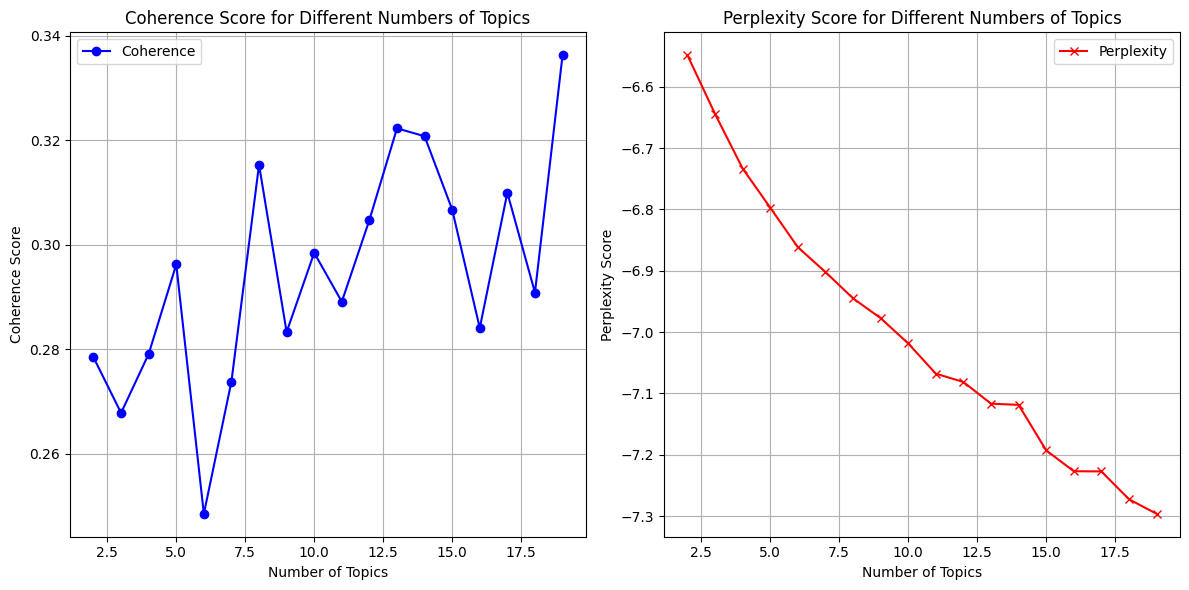

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Custom stopwords
custom_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many', 'awesome', 'best', 'also', 'machine_learning', 'sql', 'great',
}
all_stopwords = set(stopwords.words('english')).union(custom_stopwords)

# Synonym normalization dictionary
synonyms = {
    'ai': 'artificial intelligence',
    'ml': 'machine learning',
    'dl': 'deep learning',
    'nlp': 'natural language processing'
}

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing functions
def normalize_text(text):
    """Replace synonyms with normalized terms."""
    for key, value in synonyms.items():
        text = text.replace(key, value)
    return text

def preprocess(text):
    """Perform text preprocessing."""
    text = normalize_text(text)  # Normalize synonyms
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return tokens

# Bigram and trigram detection function
def detect_ngrams(processed_docs):
    """Detect bigrams and trigrams."""
    bigram = Phrases(processed_docs, min_count=2, threshold=10)
    trigram = Phrases(bigram[processed_docs], threshold=10)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    processed_docs = [bigram_mod[doc] for doc in processed_docs]
    processed_docs = [trigram_mod[doc] for doc in processed_docs]
    return processed_docs

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Load and preprocess data
df = train_df.iloc[:500]  # Adjust to load up to 500 reviews
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Detect n-grams in the processed documents
processed_docs = detect_ngrams(df['processed_reviews'].tolist())

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 50
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_3_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Assign dominant topic and topic summary
df['dominant_topic'] = [assign_topic(final_model, bow) for bow in corpus]
df['topic_summary'] = df['dominant_topic'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

# Create the labeled DataFrame
labeled_df = df[['reviews', 'processed_reviews', 'dominant_topic', 'topic_summary']]

# Print the topic summary
print("\nTopic Summary:")
for topic_id, keywords in topic_summary.items():
    print(f"Topic {topic_id}: {', '.join(keywords)}")

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df)

# Compute Coherence and Perplexity Scores
num_topics_range = range(2, 20)
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Testing LDA with just additional stopwords for 500 data points

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-8-6e45d96a4149>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_reviews'] = df['reviews'].apply(preprocess)


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9

Topic Summary:
Topic 0: great, learn, good, need, really
Topic 1: well, awesome, gives, solid, machine
Topic 2: learning, learn, experience, really, many
Topic 3: understand, data, python, learning, basic
Topic 4: coursera, good, lot, thank, first

Labeled DataFrame:
                                               reviews  \
0    Andrew Ng has provided a fantastic resource fo...   
1    Peer graded assingments take a lot of time bec...   
2    This course was the first actual course for Pr...   
3    The best course to start with if you are enter...   
4    I wanted to learn more about Functional Progra...   
..                                                 ...   
495  The Experience was really good

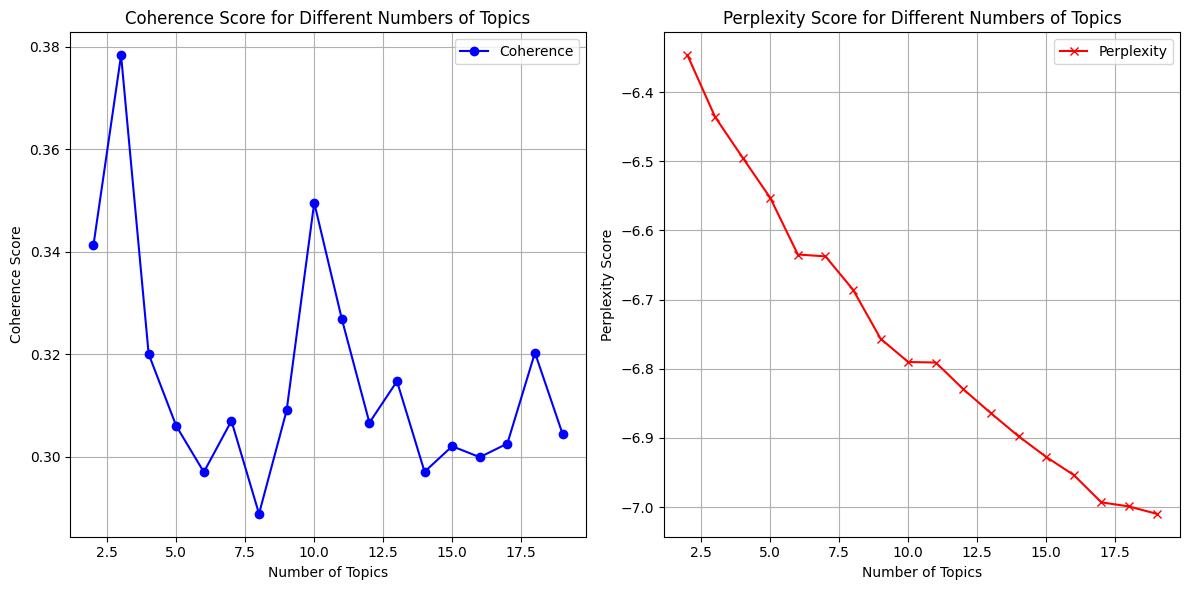

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define text preprocessing function
def preprocess(text):
    additional_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development'}
    all_stopwords = set(stopwords.words('english')).union(additional_stopwords)

    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords

    return tokens

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Load and preprocess data
df = train_df.iloc[:500]  # Adjust to load up to 500 reviews
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 50
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Assign dominant topic and topic summary
df.loc[:, 'dominant_topic'] = [assign_topic(final_model, bow) for bow in corpus]
df.loc[:, 'topic_summary'] = df['dominant_topic'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

# Create the labeled DataFrame
labeled_df = df[['reviews', 'processed_reviews', 'dominant_topic', 'topic_summary']]

# Print the topic summary
print("\nTopic Summary:")
for topic_id, keywords in topic_summary.items():
    print(f"Topic {topic_id}: {', '.join(keywords)}")

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df)

# Compute Coherence and Perplexity Scores
num_topics_range = range(2, 20)
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Adding additional stopwords based on results

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-9-a2eb35f61e32>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_reviews'] = df['reviews'].apply(preprocess)


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9

Topic Summary:
Topic 0: great, thanks, courses, life, well
Topic 1: learning, machine, sql, experience, learn
Topic 2: understand, great, helped, applications, instructor
Topic 3: great, learn, helpful, beginners, concepts
Topic 4: need, university, amazing, get, know

Labeled DataFrame:
                                               reviews  \
0    Andrew Ng has provided a fantastic resource fo...   
1    Peer graded assingments take a lot of time bec...   
2    This course was the first actual course for Pr...   
3    The best course to start with if you are enter...   
4    I wanted to learn more about Functional Progra...   
..                                                 ...   
495  The Exper

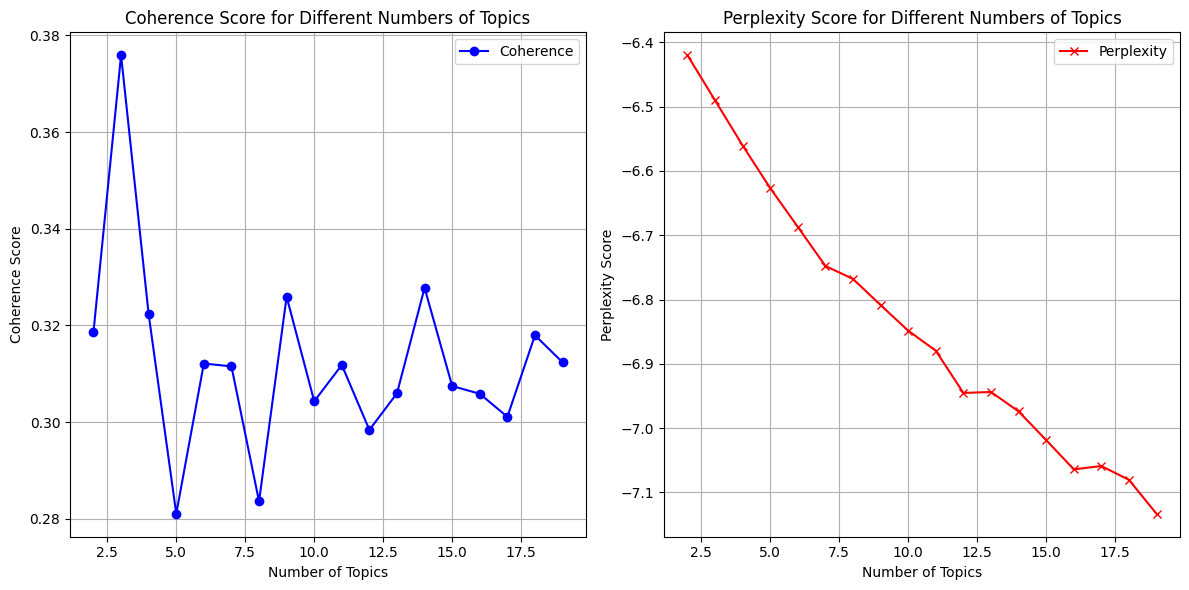

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define text preprocessing function
def preprocess(text):
    additional_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
    'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many'}
    all_stopwords = set(stopwords.words('english')).union(additional_stopwords)

    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords

    return tokens

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Load and preprocess data
df = train_df.iloc[:500]  # Adjust to load up to 500 reviews
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 50
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_1_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Assign dominant topic and topic summary
df.loc[:, 'dominant_topic'] = [assign_topic(final_model, bow) for bow in corpus]
df.loc[:, 'topic_summary'] = df['dominant_topic'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

# Create the labeled DataFrame
labeled_df = df[['reviews', 'processed_reviews', 'dominant_topic', 'topic_summary']]

# Print the topic summary
print("\nTopic Summary:")
for topic_id, keywords in topic_summary.items():
    print(f"Topic {topic_id}: {', '.join(keywords)}")

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df)

# Compute Coherence and Perplexity Scores
num_topics_range = range(2, 20)
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**Further Experiments usig results from 500 on the whole dataset**

Just additional stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9
Checkpoint saved for batch 10
Checkpoint saved for batch 11
Checkpoint saved for batch 12
Checkpoint saved for batch 13
Checkpoint saved for batch 14
Checkpoint saved for batch 15
Checkpoint saved for batch 16
Checkpoint saved for batch 17
Checkpoint saved for batch 18
Checkpoint saved for batch 19
Checkpoint saved for batch 20
Checkpoint saved for batch 21
Checkpoint saved for batch 22
Checkpoint saved for batch 23
Checkpoint saved for batch 24
Checkpoint saved for batch 25
Checkpoint saved for batch 26
Checkpoint saved for batch 27
Checkpoint saved for batch 28
Checkpoint saved for batch 29
Checkpoint saved for batch 30
Checkpoint saved for batch 31
Checkpoint saved for batch 32
Checkpoint saved for

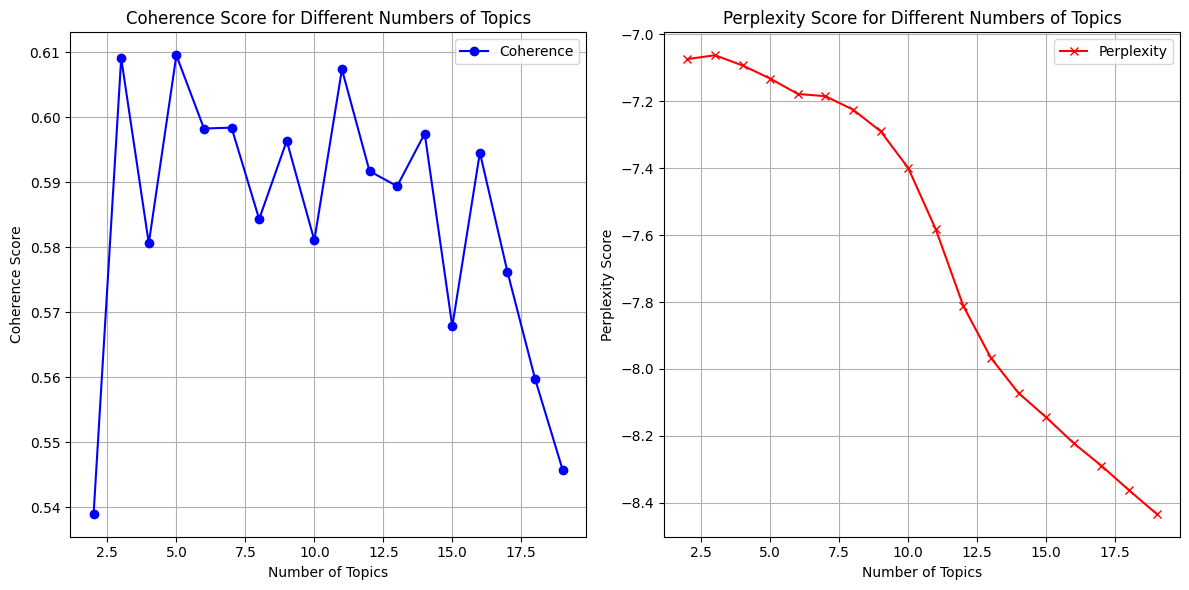

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define text preprocessing function
def preprocess(text):
    additional_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many', 'awesome', 'best', 'also', 'machine_learning', 'sql', 'great',}
    all_stopwords = set(stopwords.words('english')).union(additional_stopwords)

    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords

    return tokens

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Load and preprocess data
df = train_df
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 100
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_additional_stopwords_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Assign dominant topic and topic summary
df.loc[:, 'dominant_topic'] = [assign_topic(final_model, bow) for bow in corpus]
df.loc[:, 'topic_summary'] = df['dominant_topic'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

# Create the labeled DataFrame
labeled_additional_words_df = df[['reviews', 'processed_reviews', 'dominant_topic', 'topic_summary']]

# Print the topic summary
print("\nTopic Summary:")
for topic_id, keywords in topic_summary.items():
    print(f"Topic {topic_id}: {', '.join(keywords)}")

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_additional_words_df)

# Compute Coherence and Perplexity Scores
num_topics_range = range(2, 20)
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


More preprocessing steps

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9
Checkpoint saved for batch 10
Checkpoint saved for batch 11
Checkpoint saved for batch 12
Checkpoint saved for batch 13
Checkpoint saved for batch 14
Checkpoint saved for batch 15
Checkpoint saved for batch 16
Checkpoint saved for batch 17
Checkpoint saved for batch 18
Checkpoint saved for batch 19
Checkpoint saved for batch 20
Checkpoint saved for batch 21
Checkpoint saved for batch 22
Checkpoint saved for batch 23
Checkpoint saved for batch 24
Checkpoint saved for batch 25
Checkpoint saved for batch 26
Checkpoint saved for batch 27
Checkpoint saved for batch 28
Checkpoint saved for batch 29
Checkpoint saved for batch 30
Checkpoint saved for batch 31
Checkpoint saved for batch 32
Checkpoint saved for

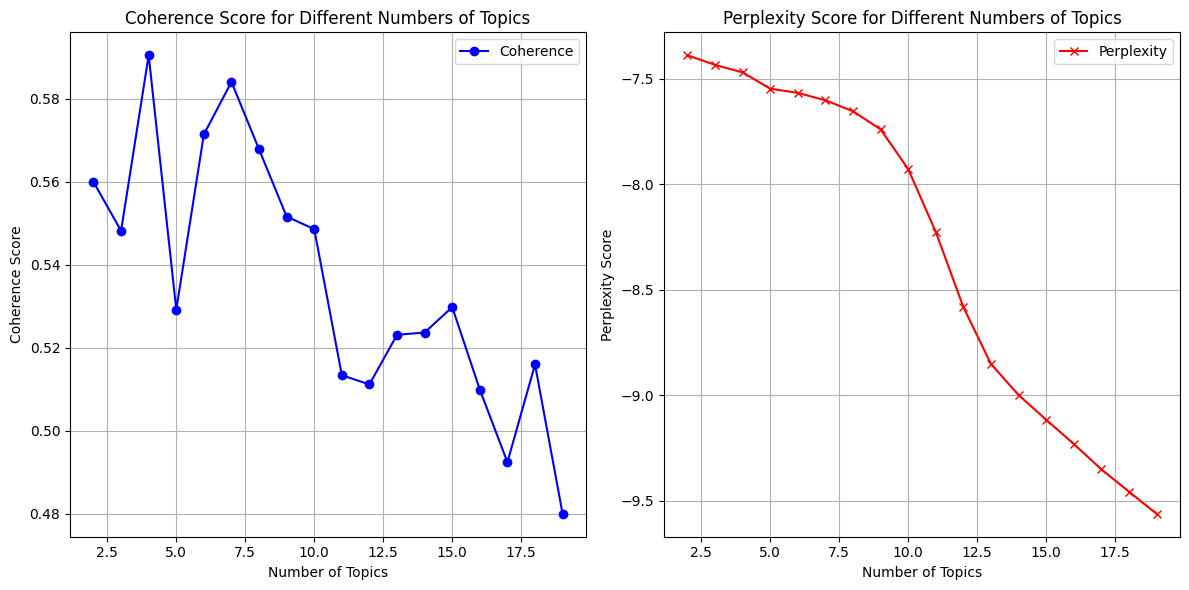

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Custom stopwords
custom_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many', 'awesome', 'best', 'also', 'machine_learning', 'sql', 'great',
}
all_stopwords = set(stopwords.words('english')).union(custom_stopwords)

# Synonym normalization dictionary
synonyms = {
    'ai': 'artificial intelligence',
    'ml': 'machine learning',
    'dl': 'deep learning',
    'nlp': 'natural language processing'
}

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing functions
def normalize_text(text):
    """Replace synonyms with normalized terms."""
    for key, value in synonyms.items():
        text = text.replace(key, value)
    return text

def preprocess(text):
    """Perform text preprocessing."""
    text = normalize_text(text)  # Normalize synonyms
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return tokens

# Bigram and trigram detection function
def detect_ngrams(processed_docs):
    """Detect bigrams and trigrams."""
    bigram = Phrases(processed_docs, min_count=2, threshold=10)
    trigram = Phrases(bigram[processed_docs], threshold=10)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    processed_docs = [bigram_mod[doc] for doc in processed_docs]
    processed_docs = [trigram_mod[doc] for doc in processed_docs]
    return processed_docs

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Load and preprocess data
df = train_df  # Adjust to load up to 500 reviews
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Detect n-grams in the processed documents
processed_docs = detect_ngrams(df['processed_reviews'].tolist())

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 100
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_all_steps_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Assign dominant topic and topic summary
df['dominant_topic'] = [assign_topic(final_model, bow) for bow in corpus]
df['topic_summary'] = df['dominant_topic'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

# Create the labeled DataFrame
labeled_all_steps_df = df[['reviews', 'processed_reviews', 'dominant_topic', 'topic_summary']]

# Print the topic summary
print("\nTopic Summary:")
for topic_id, keywords in topic_summary.items():
    print(f"Topic {topic_id}: {', '.join(keywords)}")

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_all_steps_df)

# Compute Coherence and Perplexity Scores
num_topics_range = range(2, 20)
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**Too many stopwords here, so coherence is not as good**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Tokens before stopword removal: ['andrew', 'ng', 'has', 'provided', 'a', 'fantastic', 'resource', 'for', 'those', 'looking', 'to', 'pursue', 'any', 'direction', 'in', 'machine', 'learning', '.', 'i', 'am', 'currently', 'a', 'phd', 'student', 'in', 'economics', 'and', 'i', 'found', 'this', 'course', 'to', 'really', 'be', 'the', 'breakthrough', 'i', 'needed', 'to', 'come', 'up', 'with', 'applications', 'that', 'i', 'can', 'apply', 'to', 'my', 'thesis', '!', 'i', 'highly', 'recommend', 'anyone', 'interested', 'in', 'this', 'course', 'to', 'take', 'it', '!']
Tokens after stopword removal: ['provided', 'fantastic', 'resource', 'looking', 'pursue', 'direction', 'machine', 'learning', 'currently', 'phd', 'student', 'economics', 'found', 'course', 'breakthrough', 'needed', 'come', 'applications', 'apply', 'thesis', 'highly', 'recommend', 'anyone', 'interested', 'course']
Tokens before stopword removal: ['peer', 'graded', 'assingments', 'take', 'a', 'lot', 'of', 'time', 'because', 'you', 'need'

/usr/local/lib/python3.11/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.11/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))



Topic model with the highest coherence: 2 topics with coherence nan
Topic model with the lowest coherence: 2 topics with coherence nan
Topic model with the highest perplexity: 2 topics with perplexity -2.5315703354066557
Topic model with the lowest perplexity: 9 topics with perplexity -3.4847911647047702


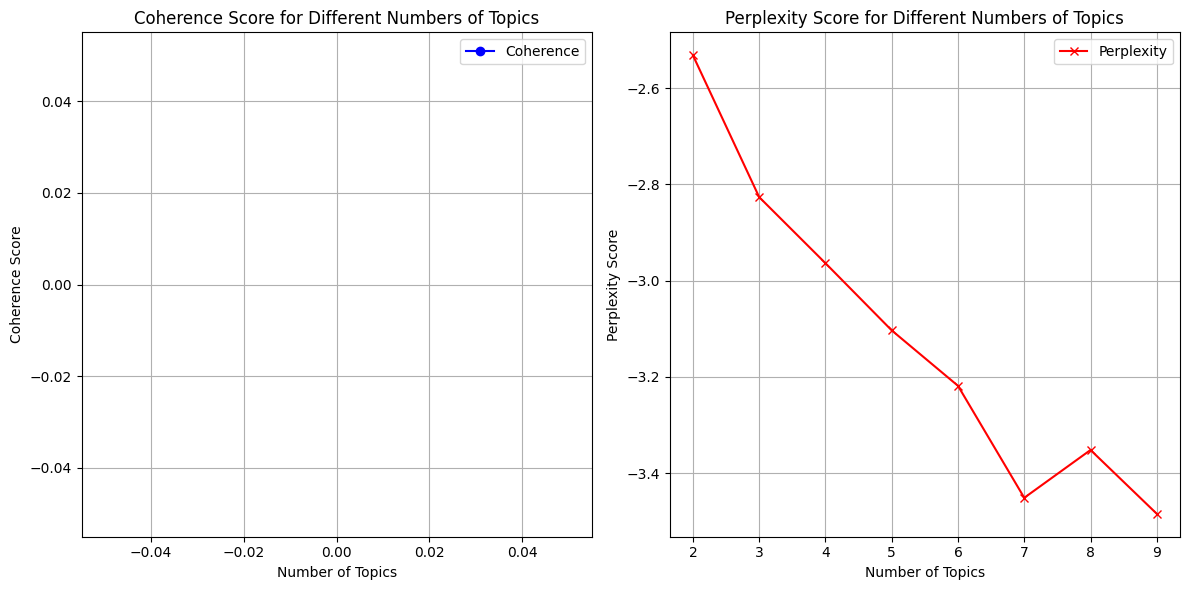

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Custom stopwords
custom_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many', 'awesome', 'best', 'also', 'machine_learning', 'sql', 'great', 'take', 'machine_learning', 'language', 'intelligencened', 'language', 'explartificial'
}
all_stopwords = set(stopwords.words('english')).union(custom_stopwords)

# Synonym normalization dictionary
synonyms = {
    'ai': 'artificial intelligence',
    'ml': 'machine learning',
    'dl': 'deep learning',
    'nlp': 'natural language processing'
}

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing functions
def normalize_text(text):
    """Replace synonyms with normalized terms."""
    for key, value in synonyms.items():
        text = text.replace(key, value)
    return text

# Preprocessing functions
def preprocess(text):
    """Perform text preprocessing."""
    text = normalize_text(text)  # Normalize synonyms
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    print(f"Tokens before stopword removal: {tokens}")  # Debugging line
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    print(f"Tokens after stopword removal: {tokens}")  # Debugging line
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return tokens

# Bigram and trigram detection function
def detect_ngrams(processed_docs):
    """Detect bigrams and trigrams."""
    bigram = Phrases(processed_docs, min_count=2, threshold=10)
    trigram = Phrases(bigram[processed_docs], threshold=10)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    processed_docs = [bigram_mod[doc] for doc in processed_docs]
    processed_docs = [trigram_mod[doc] for doc in processed_docs]
    return processed_docs

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Ensure df is a copy of the original DataFrame
df = train_df[:5].copy()  # Adjust to load up to 500 reviews

# Preprocess the reviews and store them in the 'processed_reviews' column
df.loc[:, 'processed_reviews'] = df['reviews'].apply(preprocess)

# Detect n-grams in the processed documents
processed_docs = detect_ngrams(df['processed_reviews'].tolist())

# Function to assign a topic and summary for multiple numbers of topics
def assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs):
    topic_labels = []
    topic_summaries = []

    # Loop over different numbers of topics
    for num_topics in num_topics_range:
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

        # Extract topic summaries
        topic_summary = {i: [word for word, prob in model.show_topic(i, topn=5)] for i in range(num_topics)}

        # Assign topic labels and summaries with .loc[] to avoid the SettingWithCopyWarning
        df.loc[:, f'LDA_topic_{num_topics}'] = df['processed_reviews'].apply(lambda text: assign_topic(model, dictionary.doc2bow(text)))
        df.loc[:, f'LDA_topic_summary_{num_topics}'] = df[f'LDA_topic_{num_topics}'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

        # Collect topic labels and summaries for all topics
        topic_labels.append(f'LDA_topic_{num_topics}')
        topic_summaries.append(f'LDA_topic_summary_{num_topics}')

    return df, topic_labels, topic_summaries

# Define the range of topics (from 2 to 19)
num_topics_range = range(2, 10)

# Apply the function for different numbers of topics
df, topic_labels, topic_summaries = assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs)

# Create the labeled DataFrame with topic labels and summaries for each number of topics
labeled_df = df[['reviews', 'processed_reviews'] + topic_labels + topic_summaries]

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df.head())

# Compute Coherence and Perplexity Scores for each model with a different number of topics
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


no additional stopwords, no extra steps - if this is higher than with the original stopwords, no point in pursuing stopwords as an improvement point

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9
Checkpoint saved for batch 10
Checkpoint saved for batch 11
Checkpoint saved for batch 12
Checkpoint saved for batch 13
Checkpoint saved for batch 14
Checkpoint saved for batch 15
Checkpoint saved for batch 16
Checkpoint saved for batch 17
Checkpoint saved for batch 18
Checkpoint saved for batch 19
Checkpoint saved for batch 20
Checkpoint saved for batch 21
Checkpoint saved for batch 22
Checkpoint saved for batch 23
Checkpoint saved for batch 24
Checkpoint saved for batch 25
Checkpoint saved for batch 26
Checkpoint saved for batch 27
Checkpoint saved for batch 28
Checkpoint saved for batch 29
Checkpoint saved for batch 30
Checkpoint saved for batch 31
Checkpoint saved for batch 32
Checkpoint saved for

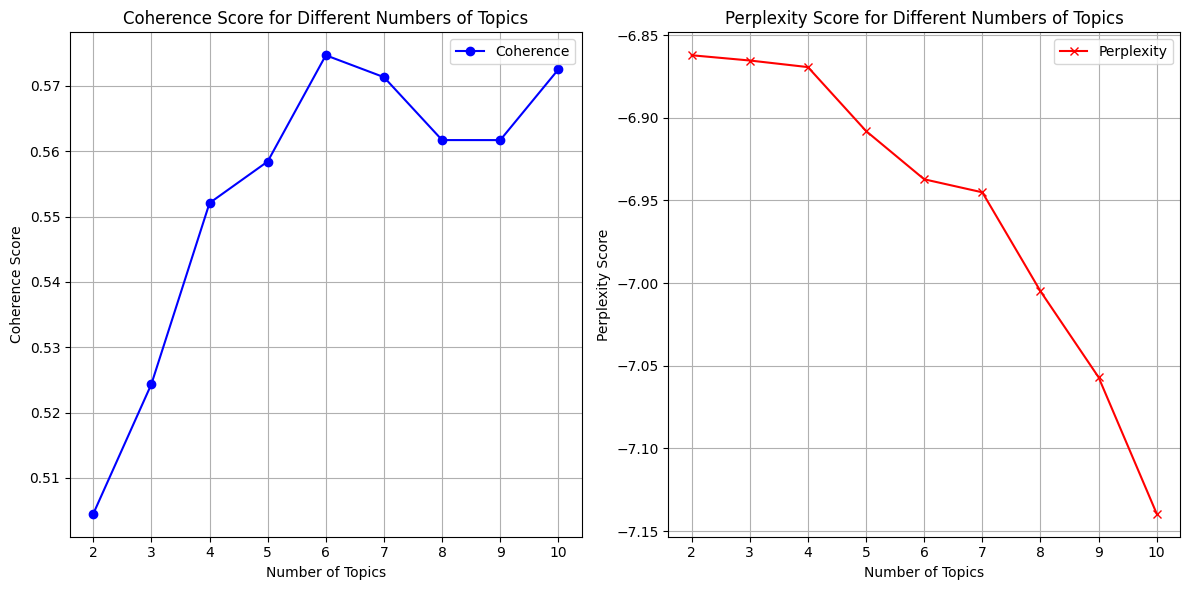

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define text preprocessing function
def preprocess(text):
    all_stopwords = set(stopwords.words('english'))

    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords

    return tokens

# Load and preprocess data
df = train_df
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 100
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_additional_stopwords_7_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Function to assign topic labels and summaries for different numbers of topics
def assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs):
    topic_labels = []
    topic_summaries = []

    # Loop over different numbers of topics
    for num_topics in num_topics_range:
        # Train LDA model
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

        # Extract topic summaries
        topic_summary = {i: [word for word, prob in model.show_topic(i, topn=5)] for i in range(num_topics)}

        # Add topic labels and summaries to the DataFrame
        df.loc[:, f'LDA_topic_{num_topics}'] = df['processed_reviews'].apply(lambda text: assign_topic(model, dictionary.doc2bow(text)))
        df.loc[:, f'LDA_topic_summary_{num_topics}'] = df[f'LDA_topic_{num_topics}'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

        # Collect topic labels and summaries for all topics
        topic_labels.append(f'LDA_topic_{num_topics}')
        topic_summaries.append(f'LDA_topic_summary_{num_topics}')

    return df, topic_labels, topic_summaries

# Define the range of topics (from 2 to 10)
num_topics_range = range(2, 11)

# Apply the function for different numbers of topics
df, topic_labels, topic_summaries = assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs)

# Create the labeled DataFrame with topic labels and summaries for each number of topics
labeled_df_complete = df[['reviews', 'processed_reviews'] + topic_labels + topic_summaries]

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df_complete)

# Compute Coherence and Perplexity Scores
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**All the additional steps don't improve, so looking for slight imporvements with slightly more stopwords to try and get and intelligible topic**

In [ ]:
labeled_df_complete
labeled_df_complete.to_csv('/content/drive/MyDrive/labeled_df_complete.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9
Checkpoint saved for batch 10
Checkpoint saved for batch 11
Checkpoint saved for batch 12
Checkpoint saved for batch 13
Checkpoint saved for batch 14
Checkpoint saved for batch 15
Checkpoint saved for batch 16
Checkpoint saved for batch 17
Checkpoint saved for batch 18
Checkpoint saved for batch 19
Checkpoint saved for batch 20
Checkpoint saved for batch 21
Checkpoint saved for batch 22
Checkpoint saved for batch 23
Checkpoint saved for batch 24
Checkpoint saved for batch 25
Checkpoint saved for batch 26
Checkpoint saved for batch 27
Checkpoint saved for batch 28
Checkpoint saved for batch 29
Checkpoint saved for batch 30
Checkpoint saved for batch 31
Checkpoint saved for batch 32
Checkpoint saved for

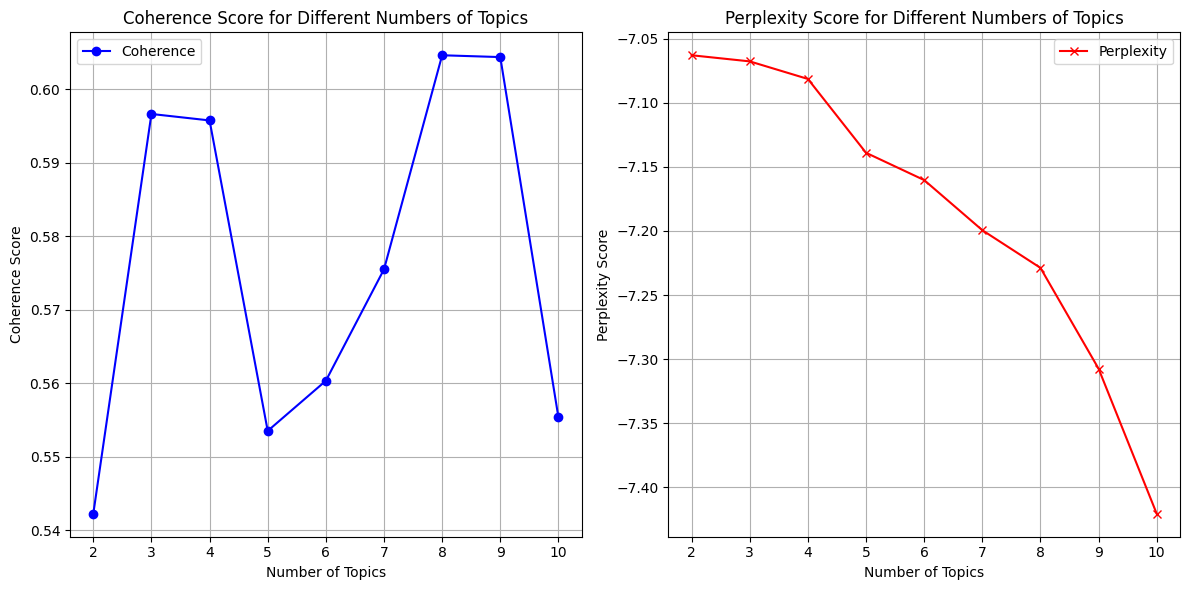

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define text preprocessing function
def preprocess(text):
    additional_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
                            'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many', 'awesome', 'best', 'also', 'machine_learning', 'sql', 'great'}
    all_stopwords = set(stopwords.words('english')).union(additional_stopwords)

    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords

    return tokens

# Load and preprocess data
df = train_df
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 100
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_additional_stopwords_1_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Function to assign topic labels and summaries for different numbers of topics
def assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs):
    topic_labels = []
    topic_summaries = []

    # Loop over different numbers of topics
    for num_topics in num_topics_range:
        # Train LDA model
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

        # Extract topic summaries
        topic_summary = {i: [word for word, prob in model.show_topic(i, topn=5)] for i in range(num_topics)}

        # Add topic labels and summaries to the DataFrame
        df.loc[:, f'LDA_topic_{num_topics}'] = df['processed_reviews'].apply(lambda text: assign_topic(model, dictionary.doc2bow(text)))
        df.loc[:, f'LDA_topic_summary_{num_topics}'] = df[f'LDA_topic_{num_topics}'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

        # Collect topic labels and summaries for all topics
        topic_labels.append(f'LDA_topic_{num_topics}')
        topic_summaries.append(f'LDA_topic_summary_{num_topics}')

    return df, topic_labels, topic_summaries

# Define the range of topics (from 2 to 10)
num_topics_range = range(2, 11)

# Apply the function for different numbers of topics
df, topic_labels, topic_summaries = assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs)

# Create the labeled DataFrame with topic labels and summaries for each number of topics
labeled_df_complete2 = df[['reviews', 'processed_reviews'] + topic_labels + topic_summaries]

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df_complete2)

# Compute Coherence and Perplexity Scores
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


So, adding stopwords makes like a 3% improvement. Do I add more stopwords or now combine w/ other things?

In [ ]:
labeled_df_complete2.head()
labeled_df_complete2.to_csv('/content/drive/MyDrive/labeled_df_complete2.csv')

additional stopwords and lemmatization, no bigrams and trigrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9
Checkpoint saved for batch 10
Checkpoint saved for batch 11
Checkpoint saved for batch 12
Checkpoint saved for batch 13
Checkpoint saved for batch 14
Checkpoint saved for batch 15
Checkpoint saved for batch 16
Checkpoint saved for batch 17
Checkpoint saved for batch 18
Checkpoint saved for batch 19
Checkpoint saved for batch 20
Checkpoint saved for batch 21
Checkpoint saved for batch 22
Checkpoint saved for batch 23
Checkpoint saved for batch 24
Checkpoint saved for batch 25
Checkpoint saved for batch 26
Checkpoint saved for batch 27
Checkpoint saved for batch 28
Checkpoint saved for batch 29
Checkpoint saved for batch 30
Checkpoint saved for batch 31
Checkpoint saved for batch 32
Checkpoint saved for

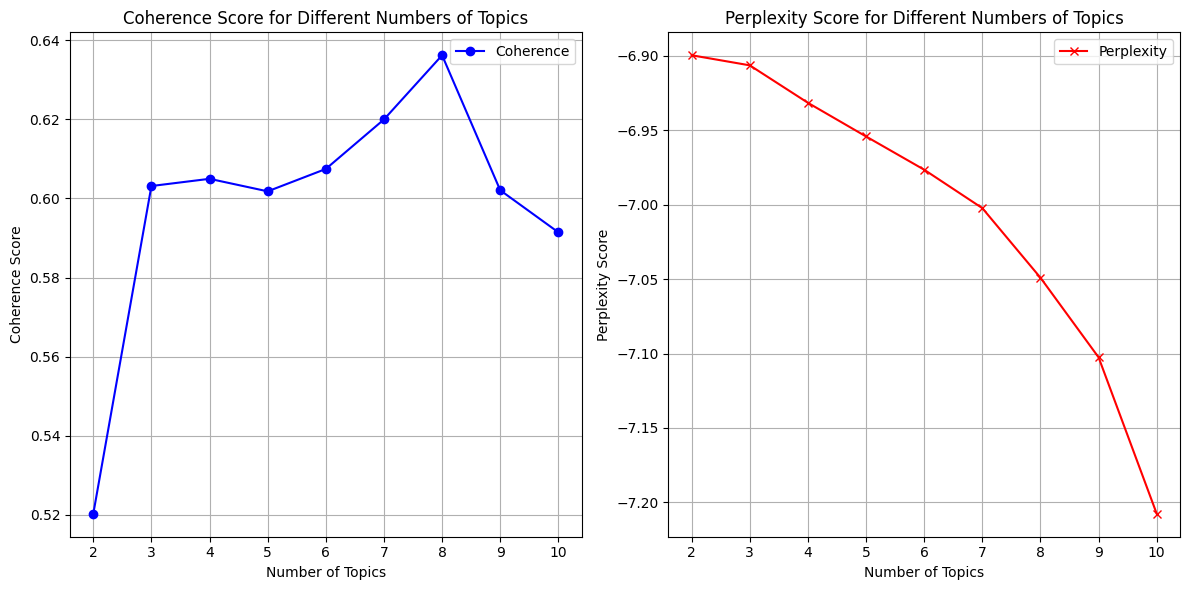

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define text preprocessing function with lemmatization
def preprocess(text):
    additional_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
    'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many', 'awesome', 'best', 'also', 'machine_learning', 'sql', 'great', 'take', 'machine_learning', 'language', 'intelligencened', 'language', 'explartificial'
    }
    all_stopwords = set(stopwords.words('english')).union(additional_stopwords)
    lemmatizer = WordNetLemmatizer()

    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens

    return tokens

# Load and preprocess data
df = train_df
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Batch processing and checkpointing
batch_size = 100
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_lemmatized_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Function to assign topic labels and summaries for different numbers of topics
def assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs):
    topic_labels = []
    topic_summaries = []

    # Loop over different numbers of topics
    for num_topics in num_topics_range:
        # Train LDA model
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

        # Extract topic summaries
        topic_summary = {i: [word for word, prob in model.show_topic(i, topn=5)] for i in range(num_topics)}

        # Add topic labels and summaries to the DataFrame
        df.loc[:, f'LDA_topic_{num_topics}'] = df['processed_reviews'].apply(lambda text: assign_topic(model, dictionary.doc2bow(text)))
        df.loc[:, f'LDA_topic_summary_{num_topics}'] = df[f'LDA_topic_{num_topics}'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

        # Collect topic labels and summaries for all topics
        topic_labels.append(f'LDA_topic_{num_topics}')
        topic_summaries.append(f'LDA_topic_summary_{num_topics}')

    return df, topic_labels, topic_summaries

# Define the range of topics (from 2 to 10)
num_topics_range = range(2, 11)

# Apply the function for different numbers of topics
df, topic_labels, topic_summaries = assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs)

# Create the labeled DataFrame with topic labels and summaries for each number of topics
labeled_df_complete5 = df[['reviews', 'processed_reviews'] + topic_labels + topic_summaries]

# Print the labeled DataFrame
print("\nLabeled DataFrame:")
print(labeled_df_complete5)

# Compute Coherence and Perplexity Scores
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
labeled_df_complete5.to_csv('/content/drive/MyDrive/labeled_df_complete5.csv', index=False)

better performance for additional stopwords and lemmatization

Next try is additional stopwords, lemmatization and bigrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Checkpoint saved for batch 0
Checkpoint saved for batch 1
Checkpoint saved for batch 2
Checkpoint saved for batch 3
Checkpoint saved for batch 4
Checkpoint saved for batch 5
Checkpoint saved for batch 6
Checkpoint saved for batch 7
Checkpoint saved for batch 8
Checkpoint saved for batch 9
Checkpoint saved for batch 10
Checkpoint saved for batch 11
Checkpoint saved for batch 12
Checkpoint saved for batch 13
Checkpoint saved for batch 14
Checkpoint saved for batch 15
Checkpoint saved for batch 16
Checkpoint saved for batch 17
Checkpoint saved for batch 18
Checkpoint saved for batch 19
Checkpoint saved for batch 20
Checkpoint saved for batch 21
Checkpoint saved for batch 22
Checkpoint saved for batch 23
Checkpoint saved for batch 24
Checkpoint saved for batch 25
Checkpoint saved for batch 26
Checkpoint saved for batch 27
Checkpoint saved for batch 28
Checkpoint saved for batch 29
Checkpoint saved for batch 30
Checkpoint saved for batch 31
Checkpoint saved for batch 32
Checkpoint saved for

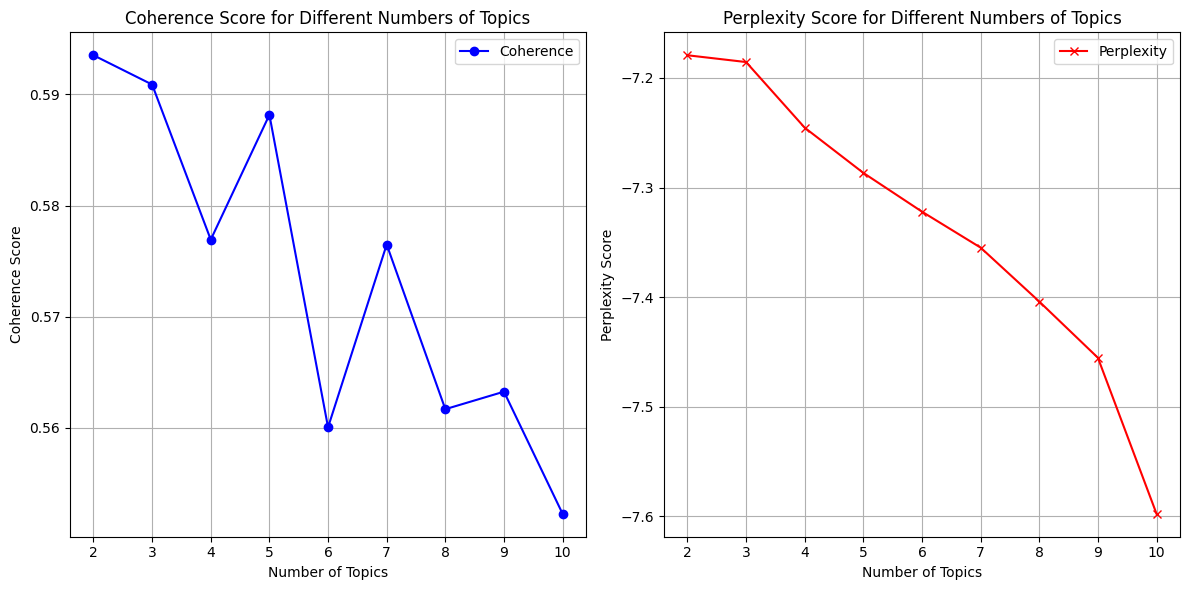

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Phrases

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define text preprocessing function with lemmatization and bigrams
def preprocess(text):
    additional_stopwords = {'programming', 'andrew', 'ng', 'study', 'industries', 'tasks', 'used', 'development', 'coursera',
    'good', 'lot', 'thank', 'first', 'data', 'python', 'excellent', 'really', 'many', 'awesome', 'best', 'also', 'machine_learning', 'sql', 'great', 'take', 'machine_learning', 'language', 'intelligencened', 'language', 'explartificial'
    }
    all_stopwords = set(stopwords.words('english')).union(additional_stopwords)
    lemmatizer = WordNetLemmatizer()

    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens

    return tokens

# Load and preprocess data
df = train_df
df['processed_reviews'] = df['reviews'].apply(preprocess)

# Create dictionary and corpus
processed_docs = df['processed_reviews'].tolist()

# Find bigrams using gensim
bigram_model = Phrases(processed_docs, min_count=5, threshold=100)  # You can adjust min_count and threshold as needed
bigram = Phrases(bigram_model[processed_docs])  # Apply bigram model

# Add bigrams to the documents
processed_docs_with_bigrams = [bigram[doc] for doc in processed_docs]

# Create dictionary and corpus with bigrams
dictionary = corpora.Dictionary(processed_docs_with_bigrams)
dictionary.filter_extremes(no_below=2, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs_with_bigrams]

# Batch processing and checkpointing
batch_size = 100
num_topics = 5
num_batches = (len(corpus) + batch_size - 1) // batch_size
final_model = None

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    # Train an LDA model for the current batch
    model = LdaModel(batch_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Checkpoint: save the model periodically
    model.save(f"lda_model_with_bigrams_batch_{batch}.model")
    print(f"Checkpoint saved for batch {batch}")

    # Store the final model for topic assignments (using the last batch)
    if batch == num_batches - 1:
        final_model = model

# Extract topic summaries
topic_summary = {i: [word for word, prob in final_model.show_topic(i, topn=5)] for i in range(num_topics)}

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Function to assign a dominant topic to a document
def assign_topic(model, bow):
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Function to assign topic labels and summaries for different numbers of topics
def assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs):
    topic_labels = []
    topic_summaries = []

    # Loop over different numbers of topics
    for num_topics in num_topics_range:
        # Train LDA model
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

        # Extract topic summaries
        topic_summary = {i: [word for word, prob in model.show_topic(i, topn=5)] for i in range(num_topics)}

        # Add topic labels and summaries to the DataFrame
        df.loc[:, f'LDA_topic_{num_topics}'] = df['processed_reviews'].apply(lambda text: assign_topic(model, dictionary.doc2bow(text)))
        df.loc[:, f'LDA_topic_summary_{num_topics}'] = df[f'LDA_topic_{num_topics}'].apply(lambda topic_id: ', '.join(topic_summary[topic_id]))

        # Collect topic labels and summaries for all topics
        topic_labels.append(f'LDA_topic_{num_topics}')
        topic_summaries.append(f'LDA_topic_summary_{num_topics}')

    return df, topic_labels, topic_summaries

# Define the range of topics (from 2 to 10)
num_topics_range = range(2, 11)

# Apply the function for different numbers of topics
df, topic_labels, topic_summaries = assign_topic_and_summary_for_different_numbers_of_topics(num_topics_range, corpus, dictionary, processed_docs_with_bigrams)

# Create the labeled DataFrame with topic labels and summaries for each number of topics
labeled_df_with_bigrams = df[['reviews', 'processed_reviews'] + topic_labels + topic_summaries]

# Print the labeled DataFrame
print("\nLabeled DataFrame with Bigrams:")
print(labeled_df_with_bigrams)

# Compute Coherence and Perplexity Scores
coherence_scores = []
perplexity_scores = []

for n_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs_with_bigrams, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Find best and worst coherence and perplexity
max_coherence = max(coherence_scores)
min_coherence = min(coherence_scores)
best_coherence_topics = num_topics_range[coherence_scores.index(max_coherence)]
worst_coherence_topics = num_topics_range[coherence_scores.index(min_coherence)]

max_perplexity = max(perplexity_scores)
min_perplexity = min(perplexity_scores)
best_perplexity_topics = num_topics_range[perplexity_scores.index(max_perplexity)]
worst_perplexity_topics = num_topics_range[perplexity_scores.index(min_perplexity)]

# Print the results
print(f"\nTopic model with the highest coherence: {best_coherence_topics} topics with coherence {max_coherence}")
print(f"Topic model with the lowest coherence: {worst_coherence_topics} topics with coherence {min_coherence}")
print(f"Topic model with the highest perplexity: {best_perplexity_topics} topics with perplexity {max_perplexity}")
print(f"Topic model with the lowest perplexity: {worst_perplexity_topics} topics with perplexity {min_perplexity}")

# Plot Coherence and Perplexity Scores
plt.figure(figsize=(12, 6))

# Coherence scores
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, marker='o', color='b', label='Coherence')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.legend()

# Perplexity scores
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, marker='x', color='r', label='Perplexity')
plt.title('Perplexity Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
labeled_df_with_bigrams.to_csv('/content/drive/MyDrive/labeled_df_with_bigrams.csv', index=False)

results are worse, so no point in pursuing trigrams. for further improvements, could try more stop words

stopwords and lemmatization and trigrams

# Making use of additional stopwords and lemmatization

trying to come up with title for 3,4 and 8 topics, since 3,4 are at the "elbow" of the coherence score curve and 8 has the highest coherence

In [1]:
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
df_tolabel = pd.read_csv('/content/drive/MyDrive/labeled_df_complete5.csv')
df_tolabel

Mounted at /content/drive


,reviews,processed_reviews,LDA_topic_2,LDA_topic_3,LDA_topic_4,LDA_topic_5,LDA_topic_6,LDA_topic_7,LDA_topic_8,LDA_topic_9,LDA_topic_10,LDA_topic_summary_2,LDA_topic_summary_3,LDA_topic_summary_4,LDA_topic_summary_5,LDA_topic_summary_6,LDA_topic_summary_7,LDA_topic_summary_8,LDA_topic_summary_9,LDA_topic_summary_10
0,Andrew Ng has provided a fantastic resource fo...,"['provided', 'fantastic', 'resource', 'looking...",0,1,1,1,1,5,4,5,9,"assignment, learning, machine, introduction, time","learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, concept, algorithm, ml","learning, machine, algorithm, concept, ml","learning, machine, algorithm, ml, concept","learning, machine, algorithm, ml, concept","assignment, information, forum, challenging, help","useful, problem, real, practical, knowledge"
1,Peer graded assingments take a lot of time bec...,"['peer', 'graded', 'assingments', 'time', 'nee...",0,0,0,2,0,2,2,5,6,"assignment, learning, machine, introduction, time","assignment, time, video, would, lecture","assignment, video, time, lecture, would","much, class, one, time, thanks","assignment, video, time, would, lecture","assignment, video, time, lecture, material","assignment, time, week, would, video","assignment, information, forum, challenging, help","time, know, code, one, get"
2,This course was the first actual course for Pr...,"['course', 'actual', 'course', 'college', 'tak...",1,2,3,3,5,0,1,4,8,"learning, learn, beginner, easy, basic","learn, beginner, easy, way, thanks","thanks, learn, way, teaching, much","easy, well, understand, instructor, way","class, thanks, learning, much, learn","thanks, much, chuck, learn, learning","class, much, thanks, one, learn","easy, understand, way, learn, teaching","easy, way, understand, learn, teaching"
3,The best course to start with if you are enter...,"['course', 'start', 'entering', 'field', 'mach...",1,1,1,1,1,5,4,8,3,"learning, learn, beginner, easy, basic","learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, concept, algorithm, ml","learning, machine, algorithm, concept, ml","learning, machine, algorithm, ml, concept","learning, machine, algorithm, ml, concept","beginner, recommend, learn, want, knowledge","learning, machine, algorithm, ml, concept"
4,I wanted to learn more about Functional Progra...,"['wanted', 'learn', 'functional', 'prepare', '...",0,0,0,4,0,3,1,2,3,"assignment, learning, machine, introduction, time","assignment, time, video, would, lecture","assignment, video, time, lecture, would","assignment, video, lecture, would, code","assignment, video, time, would, lecture","basic, beginner, science, learn, introduction","class, much, thanks, one, learn","would, assignment, time, code, bit","learning, machine, algorithm, ml, concept"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39733,This course is one of the best courses that sh...,"['course', 'one', 'course', 'show', 'ability',...",0,0,0,2,2,6,4,6,6,"assignment, learning, machine, introduction, time","assignment, time, video, would, lecture","assignment, video, time, lecture, would","much, class, one, time, thanks","basic, science, introduction, tool, useful","class, looking, specialization, forward, learned","learning, machine, algorithm, ml, concept","learning, thanks, one, time, experience","time, know, code, one, get"
39734,"The details about Objects, References and Alia...","['detail', 'object', 'reference', 'alias', 'cl...",0,2,2,3,0,1,6,0,1,"assignment, learning, machine, introduction, time","learn, beginner, easy, way, thanks","basic, beginner, easy, learn, science","easy, well, understand, instructor, way","assignment, video, time, would, lecture","well, easy, understand, concept, clear","well, assignment, material, exercise, lecture","well, assignment, material, concept, lecture","assignment, video, lecture, would, bit"
39735,This course gives very basic infor

only keeping 3,4, and 8 clusters

In [3]:
newdf_tolabel = df_tolabel.drop(["LDA_topic_2", "LDA_topic_5", "LDA_topic_6", "LDA_topic_7", "LDA_topic_9", "LDA_topic_10", "LDA_topic_summary_2", "LDA_topic_summary_5", "LDA_topic_summary_6", "LDA_topic_summary_7", "LDA_topic_summary_9", "LDA_topic_summary_10"], axis='columns')
newdf_tolabel

,reviews,processed_reviews,LDA_topic_3,LDA_topic_4,LDA_topic_8,LDA_topic_summary_3,LDA_topic_summary_4,LDA_topic_summary_8
0,Andrew Ng has provided a fantastic resource fo...,"['provided', 'fantastic', 'resource', 'looking...",1,1,4,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept"
1,Peer graded assingments take a lot of time bec...,"['peer', 'graded', 'assingments', 'time', 'nee...",0,0,2,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","assignment, time, week, would, video"
2,This course was the first actual course for Pr...,"['course', 'actual', 'course', 'college', 'tak...",2,3,1,"learn, beginner, easy, way, thanks","thanks, learn, way, teaching, much","class, much, thanks, one, learn"
3,The best course to start with if you are enter...,"['course', 'start', 'entering', 'field', 'mach...",1,1,4,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept"
4,I wanted to learn more about Functional Progra...,"['wanted', 'learn', 'functional', 'prepare', '...",0,0,1,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","class, much, thanks, one, learn"
...,...,...,...,...,...,...,...,...
39733,This course is one of the best courses that sh...,"['course', 'one', 'course', 'show', 'ability',...",0,0,4,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","learning, machine, algorithm, ml, concept"
39734,"The details about Objects, References and Alia...","['detail', 'object', 'reference', 'alias', 'cl...",2,2,6,"learn, beginner, easy, way, thanks","basic, beginner, easy, learn, science","well, assignment, material, exercise, lecture"
39735,This course gives very basic information about...,"['course', 'give', 'basic', 'information', 'us...",0,0,7,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","beginner, recommend, learn, want, would"
39736,Awesome courseDr. Chuck is great,"['coursedr', 'chuck']",2,3,3,"learn, beginner, easy, way, thanks","thanks, learn, way, teaching, much","easy, understand, way, instructor, teaching"


In [7]:
newdf_tolabel.to_csv('/content/drive/MyDrive/df_new_topos_tolabel.csv')

In [9]:
import pandas as pd
df_new_topos_tolabel = pd.read_csv('/content/drive/MyDrive/df_new_topos_tolabel.csv')
df_new_topos_tolabel

,Unnamed: 0,reviews,processed_reviews,LDA_topic_3,LDA_topic_4,LDA_topic_8,LDA_topic_summary_3,LDA_topic_summary_4,LDA_topic_summary_8
0,0,Andrew Ng has provided a fantastic resource fo...,"['provided', 'fantastic', 'resource', 'looking...",1,1,4,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept"
1,1,Peer graded assingments take a lot of time bec...,"['peer', 'graded', 'assingments', 'time', 'nee...",0,0,2,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","assignment, time, week, would, video"
2,2,This course was the first actual course for Pr...,"['course', 'actual', 'course', 'college', 'tak...",2,3,1,"learn, beginner, easy, way, thanks","thanks, learn, way, teaching, much","class, much, thanks, one, learn"
3,3,The best course to start with if you are enter...,"['course', 'start', 'entering', 'field', 'mach...",1,1,4,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept"
4,4,I wanted to learn more about Functional Progra...,"['wanted', 'learn', 'functional', 'prepare', '...",0,0,1,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","class, much, thanks, one, learn"
...,...,...,...,...,...,...,...,...,...
39733,39733,This course is one of the best courses that sh...,"['course', 'one', 'course', 'show', 'ability',...",0,0,4,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","learning, machine, algorithm, ml, concept"
39734,39734,"The details about Objects, References and Alia...","['detail', 'object', 'reference', 'alias', 'cl...",2,2,6,"learn, beginner, easy, way, thanks","basic, beginner, easy, learn, science","well, assignment, material, exercise, lecture"
39735,39735,This course gives very basic information about...,"['course', 'give', 'basic', 'information', 'us...",0,0,7,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","beginner, recommend, learn, want, would"
39736,39736,Awesome courseDr. Chuck is great,"['coursedr', 'chuck']",2,3,3,"learn, beginner, easy, way, thanks","thanks, learn, way, teaching, much","easy, understand, way, instructor, teaching"


# Assigning new topic names based on new topic summaries

In [11]:
import pandas as pd

# Load your dataframe
df_new_topos_labelled = df_new_topos_tolabel.copy()

# Define the mappings
lda_topic_3_mapping = {
    0: "Course Structure/Organisation and usefulness",
    1: "Learning Outcomes",
    2: "Teaching Style / Interaction and Accessibility"
}

lda_topic_4_mapping = {
    0: "Course Material and Learning Outcomes",
    1: "Learning Outcomes",
    2: "Usefulness and Accessibility",
    3: "Teaching Style and Content"
}

lda_topic_8_mapping = {
    0: "Teaching Style / Interaction and Accessibility",
    1: "Usefulness and learning Experience/Sentiment",
    2: "Course Material and Resources",
    3: "Teaching Style/Engagement and Course Structure",
    4: "Course Materials and Content",
    5: "Usefulness and Application",
    6: "Course materials, activities and Learning Resources",
    7: "Course Accessibility and Prior Knowledge Requirement"
}

# Apply the mappings to the respective columns
df_new_topos_labelled['LDA_topic_3'] = df_new_topos_labelled['LDA_topic_3'].replace(lda_topic_3_mapping)
df_new_topos_labelled['LDA_topic_4'] = df_new_topos_labelled['LDA_topic_4'].replace(lda_topic_4_mapping)
df_new_topos_labelled['LDA_topic_8'] = df_new_topos_labelled['LDA_topic_8'].replace(lda_topic_8_mapping)

# Save or view the updated dataframe
df_new_topos_labelled.head()
# Optionally save the updated dataframe back to a CSV
# df_new_topos_tolabel.to_csv('/content/drive/MyDrive/df_new_topos_tolabel_updated.csv', index=False)


,Unnamed: 0,reviews,processed_reviews,LDA_topic_3,LDA_topic_4,LDA_topic_8,LDA_topic_summary_3,LDA_topic_summary_4,LDA_topic_summary_8
0,0,Andrew Ng has provided a fantastic resource fo...,"['provided', 'fantastic', 'resource', 'looking...",Learning Outcomes,Learning Outcomes,Course Materials and Content,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept"
1,1,Peer graded assingments take a lot of time bec...,"['peer', 'graded', 'assingments', 'time', 'nee...",Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Course Material and Resources,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","assignment, time, week, would, video"
2,2,This course was the first actual course for Pr...,"['course', 'actual', 'course', 'college', 'tak...",Teaching Style / Interaction and Accessibility,Teaching Style and Content,Usefulness and learning Experience/Sentiment,"learn, beginner, easy, way, thanks","thanks, learn, way, teaching, much","class, much, thanks, one, learn"
3,3,The best course to start with if you are enter...,"['course', 'start', 'entering', 'field', 'mach...",Learning Outcomes,Learning Outcomes,Course Materials and Content,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept"
4,4,I wanted to learn more about Functional Progra...,"['wanted', 'learn', 'functional', 'prepare', '...",Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Usefulness and learning Experience/Sentiment,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","class, much, thanks, one, learn"


Merging previous and new topic labels

In [13]:
# Rename the columns
df_new_topos_labelled.rename(columns={
    'LDA_topic_3': 'LDA_topic_3_v2',
    'LDA_topic_4': 'LDA_topic_4_v2',
    'LDA_topic_8': 'LDA_topic_8_v2'
}, inplace=True)

# Verify the column names
print(df_new_topos_labelled)

# Save the updated dataframe if needed
# df_new_topos_tolabel.to_csv('/content/drive/MyDrive/df_new_topos_tolabel_renamed.csv', index=False)


       Unnamed: 0                                            reviews  \
0               0  Andrew Ng has provided a fantastic resource fo...   
1               1  Peer graded assingments take a lot of time bec...   
2               2  This course was the first actual course for Pr...   
3               3  The best course to start with if you are enter...   
4               4  I wanted to learn more about Functional Progra...   
...           ...                                                ...   
39733       39733  This course is one of the best courses that sh...   
39734       39734  The details about Objects, References and Alia...   
39735       39735  This course gives very basic information about...   
39736       39736                   Awesome courseDr. Chuck is great   
39737       39737  Clear and precise teaching methods by Dr. Char...   

                                       processed_reviews  \
0      ['provided', 'fantastic', 'resource', 'looking...   
1      ['peer',

In [14]:
all_reviews = pd.read_csv('/content/drive/MyDrive/final_processed.csv')
all_reviews

,Unnamed: 0,reviews,date_reviews,rating,course_id,month,departments,name,institution,sentiment_from_rating,emotion_label,sentiment_label_from_review,BART_Topic,LDA_topic_3,LDA_topic_4,topic_summary
0,0,Andrew Ng has provided a fantastic resource fo...,2017-09-12,5,machine-learning,2017-09,Computer Science,Machine Learning,Stanford University,positive,enjoyment/happiness,positive,"['Course Material', 'Instructor']",Learning Outcomes,Learning Outcomes,"['Learning Outcomes', 'Course Material', 'Inst..."
1,1,This course was the first actual course for Pr...,2019-01-31,5,python,2019-01,Computer Science,Programming for Everybody (Getting Started wit...,University of Michigan,positive,enjoyment/happiness,positive,"['Instructor', 'Course Material']",Utility and Usefulness,Course Material and Understanding,"['Course Material and Understanding', 'Utility..."
2,2,The best course to start with if you are enter...,2017-08-20,5,machine-learning,2017-08,Computer Science,Machine Learning,Stanford University,positive,approval,positive,"['Course Material', 'Instructor']",Learning Outcomes,Learning Outcomes,"['Learning Outcomes', 'Course Material', 'Inst..."
3,3,I wanted to learn more about Functional Progra...,2020-07-12,4,programming-languages,2020-07,Computer Science,"Programming Languages, Part A",University of Washington,positive,approval,positive,"['Course Material', 'Instructor']",Course Material,Course Material and Understanding,"['Course Material and Understanding', 'Instruc..."
4,4,"Thoroughly enjoyed the course. Yes, despite my...",2018-03-14,5,machine-learning,2018-03,Computer Science,Machine Learning,Stanford University,positive,enjoyment/happiness,positive,"['Course Material', 'Instructor']",Utility and Usefulness,Learning Outcomes,"['Utility and Usefulness', 'Learning Outcomes'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36687,37729,This course is one of the best courses that sh...,2019-02-12,4,python-data-visualization,2019-02,Computer Science,"Capstone: Retrieving, Processing, and Visualiz...",University of Michigan,positive,enjoyment/happiness,positive,"['Course Material', 'Grading']",Utility and Usefulness,Learning Outcomes,"['Utility and Usefulness', 'Learning Outcomes'..."
36688,37730,"The details about Objects, References and Alia...",2019-08-08,4,python-basics,2019-08,Computer Science,Python Basics,University of Michigan,positive,enjoyment/happiness,positive,"['Course Material', 'Instructor']",Course Material,Course Engagement and Course Feelings(Sentiment),['Course Engagement and Course Feelings(Sentim...
36689,37731,This course gives very basic information about...,2016-02-19,4,python-databases,2016-02,Computer Science,Using Databases with Python,University of Michigan,positive,enjoyment/happiness,positive,"['Course Material', 'Lectures']",Course Material,Course Structure,"['Course Structure', 'Course Material', 'Lectu..."
36690,37732,Awesome courseDr. Chuck is great,2019-02-03,4,python,2019-02,Computer Science,Programming for Everybody (Getting Started wit...,University of Michigan,positive,enjoyment/happiness,positive,"['Course Material', 'Instructor']",Utility and Usefulness,Course Material and Understanding,"['Course Material and Understanding', 'Utility..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [17]:
print(df_new_topos_labelled.columns)
print(all_reviews.columns)


Index(['Unnamed: 0', 'reviews', 'processed_reviews', 'LDA_topic_3_v2',
       'LDA_topic_4_v2', 'LDA_topic_8_v2', 'LDA_topic_summary_3',
       'LDA_topic_summary_4', 'LDA_topic_summary_8'],
      dtype='object')
Index(['Unnamed: 0', 'reviews', 'date_reviews', 'rating', 'course_id', 'month',
       'departments', 'name', 'institution', 'sentiment_from_rating',
       'emotion_label', 'sentiment_label_from_review', 'BART_Topic',
       'LDA_topic_3', 'LDA_topic_4', 'topic_summary'],
      dtype='object')


merge new labels with old (dfs only)

In [18]:
# Merge the two DataFrames on the 'reviews' column
merged_df = pd.merge(
    df_new_topos_labelled,  # First DataFrame
    all_reviews,           # Second DataFrame
    on='reviews',          # Common column to join on
    how='inner'            # Type of join: 'inner', 'left', 'right', or 'outer'
)

# Check the result
print(merged_df.columns)

# Optionally save the merged DataFrame to a file
# merged_df.to_csv('/content/drive/MyDrive/merged_df.csv', index=False)

merged_df = merged_df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], errors='ignore')
merged_df.head()


Index(['Unnamed: 0_x', 'reviews', 'processed_reviews', 'LDA_topic_3_v2',
       'LDA_topic_4_v2', 'LDA_topic_8_v2', 'LDA_topic_summary_3',
       'LDA_topic_summary_4', 'LDA_topic_summary_8', 'Unnamed: 0_y',
       'date_reviews', 'rating', 'course_id', 'month', 'departments', 'name',
       'institution', 'sentiment_from_rating', 'emotion_label',
       'sentiment_label_from_review', 'BART_Topic', 'LDA_topic_3',
       'LDA_topic_4', 'topic_summary'],
      dtype='object')


,reviews,processed_reviews,LDA_topic_3_v2,LDA_topic_4_v2,LDA_topic_8_v2,LDA_topic_summary_3,LDA_topic_summary_4,LDA_topic_summary_8,date_reviews,rating,...,departments,name,institution,sentiment_from_rating,emotion_label,sentiment_label_from_review,BART_Topic,LDA_topic_3,LDA_topic_4,topic_summary
0,Andrew Ng has provided a fantastic resource fo...,"['provided', 'fantastic', 'resource', 'looking...",Learning Outcomes,Learning Outcomes,Course Materials and Content,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept",2017-09-12,5,...,Computer Science,Machine Learning,Stanford University,positive,enjoyment/happiness,positive,"['Course Material', 'Instructor']",Learning Outcomes,Learning Outcomes,"['Learning Outcomes', 'Course Material', 'Inst..."
1,This course was the first actual course for Pr...,"['course', 'actual', 'course', 'college', 'tak...",Teaching Style / Interaction and Accessibility,Teaching Style and Content,Usefulness and learning Experience/Sentiment,"learn, beginner, easy, way, thanks","thanks, learn, way, teaching, much","class, much, thanks, one, learn",2019-01-31,5,...,Computer Science,Programming for Everybody (Getting Started wit...,University of Michigan,positive,enjoyment/happiness,positive,"['Instructor', 'Course Material']",Utility and Usefulness,Course Material and Understanding,"['Course Material and Understanding', 'Utility..."
2,The best course to start with if you are enter...,"['course', 'start', 'entering', 'field', 'mach...",Learning Outcomes,Learning Outcomes,Course Materials and Content,"learning, machine, concept, algorithm, basic","learning, machine, concept, algorithm, ml","learning, machine, algorithm, ml, concept",2017-08-20,5,...,Computer Science,Machine Learning,Stanford University,positive,approval,positive,"['Course Material', 'Instructor']",Learning Outcomes,Learning Outcomes,"['Learning Outcomes', 'Course Material', 'Inst..."
3,I wanted to learn more about Functional Progra...,"['wanted', 'learn', 'functional', 'prepare', '...",Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Usefulness and learning Experience/Sentiment,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","class, much, thanks, one, learn",2020-07-12,4,...,Computer Science,"Programming Languages, Part A",University of Washington,positive,approval,positive,"['Course Material', 'Instructor']",Course Material,Course Material and Understanding,"['Course Material and Understanding', 'Instruc..."
4,"Thoroughly enjoyed the course. Yes, despite my...","['thoroughly', 'enjoyed', 'course', 'yes', 'de...",Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Course Material and Resources,"assignment, time, video, would, lecture","assignment, video, time, lecture, would","assignment, time, week, would, video",2018-03-14,5,...,Computer Science,Machine Learning,Stanford University,positive,enjoyment/happiness,positive,"['Course Material', 'Instructor']",Utility and Usefulness,Learning Outcomes,"['Utility and Usefulness', 'Learning Outcomes'..."


Evaluation of Accuracy for 100 data points. Thought to do similarity comparison between initial topic labels and new topic labels but this may miss out new uncovered topics from the new topic labels.

In [22]:
merged_df[["reviews", "LDA_topic_3_v2", "LDA_topic_4_v2", "LDA_topic_8_v2"]]

,reviews,LDA_topic_3_v2,LDA_topic_4_v2,LDA_topic_8_v2
0,Andrew Ng has provided a fantastic resource fo...,Learning Outcomes,Learning Outcomes,Course Materials and Content
1,This course was the first actual course for Pr...,Teaching Style / Interaction and Accessibility,Teaching Style and Content,Usefulness and learning Experience/Sentiment
2,The best course to start with if you are enter...,Learning Outcomes,Learning Outcomes,Course Materials and Content
3,I wanted to learn more about Functional Progra...,Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Usefulness and learning Experience/Sentiment
4,"Thoroughly enjoyed the course. Yes, despite my...",Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Course Material and Resources
...,...,...,...,...
36883,This course is one of the best courses that sh...,Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Course Materials and Content
36884,"The details about Objects, References and Alia...",Teaching Style / Interaction and Accessibility,Usefulness and Accessibility,"Course materials, activities and Learning Reso..."
36885,This course gives very basic information about...,Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Course Accessibility and Prior Knowledge Requi...
36886,Awesome courseDr. Chuck is great,Teaching Style / Interaction and Accessibility,Teaching Style and Content,Teaching Style/Engagement and Course Structure


In [23]:
import pandas as pd

# Shuffle the DataFrame randomly
shuffled_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select rows from 0 to 100 and specific columns
random_subset = shuffled_df.loc[0:100, ["reviews", "LDA_topic_3_v2", "LDA_topic_4_v2", "LDA_topic_8_v2"]]

# Display the result
random_subset

# Optionally save the random subset
# random_subset.to_csv('/content/drive/MyDrive/random_subset.csv', index=False)


,reviews,LDA_topic_3_v2,LDA_topic_4_v2,LDA_topic_8_v2
0,Fabulous course! Covers nearly every useful l...,Course Structure/Organisation and usefulness,Learning Outcomes,Course Materials and Content
1,The course was really awesome. The instructor ...,Teaching Style / Interaction and Accessibility,Usefulness and Accessibility,Teaching Style/Engagement and Course Structure
2,Hats off to instructor for making this course ...,Teaching Style / Interaction and Accessibility,Teaching Style and Content,Usefulness and learning Experience/Sentiment
3,The best course a ever had.,Teaching Style / Interaction and Accessibility,Teaching Style and Content,Usefulness and learning Experience/Sentiment
4,"Videos, assignment and extra stuff were all gr...",Course Structure/Organisation and usefulness,Course Material and Learning Outcomes,Course Material and Resources
...,...,...,...,...
96,The best course about Machine Learning on the ...,Teaching Style / Interaction and Accessibility,Teaching Style and Content,Usefulness and learning Experience/Sentiment
97,Great Learning experience.. Thanks coursera & ...,Teaching Style / Interaction and Accessibility,Teaching Style and Content,Usefulness and learning Experience/Sentiment
98,The instructors are so passionate about what t...,Teaching Style / Interaction and Accessibility,Teaching Style and Content,"Course materials, activities and Learning Reso..."
99,a great course for python web beginners,Teaching Style / Interaction and Accessibility,Usefulness and Accessibility,Usefulness and Application


adding topics from 3 and 8 to a new summary, since results are better

In [41]:
# Ensure that BART_Topic is a string by joining the list into a string
merged_df['BART_Topic'] = merged_df['BART_Topic'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
def flatten_BART (){
    for in range(len(merged_df['BART_Topic'])):
        listAsStr = {merged_df['BART_Topic'][i]}

}

# Now concatenate all columns into 'topic_summary_v2'
merged_df['topic_summary_v2'] = merged_df["LDA_topic_3_v2"] + ', ' + merged_df["LDA_topic_8_v2"] + ', ' + merged_df["BART_Topic"]

# Display the result
merged_df['topic_summary_v2'].iloc[0]


"Learning Outcomes, Course Materials and Content, ['Course Material', 'Instructor']"

In [52]:
# Convert the list in 'BART_Topic' to a string with comma separation
merged_df['BART_Topic'] = merged_df['BART_Topic'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Now concatenate all the columns into 'topic_summary_v2'
merged_df['topic_summary_v2'] = merged_df["LDA_topic_3_v2"] + ', ' + merged_df["LDA_topic_8_v2"] + ', ' + merged_df["BART_Topic"]

# Convert the result into a list of topics by splitting by ', ' and remove extra spaces
merged_df['topic_summary_v2'] = merged_df['topic_summary_v2'].apply(lambda x: [t.strip().replace('[','').replace(']','').replace("'", "") for t in x.split(', ')])

# Optionally, remove duplicates from the list by converting it into a set and back to a list
merged_df['topic_summary_v2'] = merged_df['topic_summary_v2'].apply(lambda x: list(set(x)))

# Display the result for the first row
merged_df['topic_summary_v2'].iloc[5]

['Learning Outcomes',
 'Teaching Style/Engagement and Course Structure',
 'Instructor',
 'Course Material']

In [53]:
merged_df.to_csv('/content/drive/MyDrive/merged_df_improved_labels.csv', index=False)